# Covid Vaccine Study

Data: 
- 5' GEX, VDJ, and Antibody Capture data from 8 Donors after Vaccination against Sars-CoV-2. 
- Antibody capture includes Hashtagging + Epitopes
 

In [1]:
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os

import scanpy as sc
import scirpy as ir
import anndata as ann

import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from matplotlib import rcParams

C:\Users\felix.drost\Anaconda3\envs\covidVac\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sc.settings.set_figure_params(dpi=150)
sc.settings.verbosity = 3
sc.set_figure_params(vector_friendly=True, color_map='viridis', transparent=True)
sb.set_style('whitegrid')
#sb.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})

## Settings

In [3]:
path_base = '../../data/dextramer'
path_merged = f'{path_base}/01_dex_merged.h5ad'

## Join the data

In [4]:
hashtag_old = ['C0251_A02', 'C0252_A03', 'C0253_A04', 'C0254_A05', 
               'C0255_A06', 'C0256_A11', 'C0257_A15', 'C0258_A29',]

hashtag_new = ['C0251_A08', 'C0252_A04', 'C0253_A05', 'C0254_A11', 
               'C0255_A15', 'C0256_A29', 'C0257_A19', 'C0258_A25', ]

epitope_ids = ['LTDEMIAQY', 'YTNSFTRGVY', 'YLQPRTFLL', 'RLQSLQTYV', 
               'VLNDILSRL', 'KIADYNYKL', 'KCYGVSPTK', 'KVFRSSVLH', 
               'RLFRKSNLK', 'GTHWFVTQR', 'QYIKWPWYI', 'NYNYLYRLF', 
               'SPRRARSVA', 'FPQSAPHGV', 'QPYRVVVL', 'IYKTPPIKDF', ]

feature_barcode_ids = hashtag_old + hashtag_new + epitope_ids

In [5]:
adatas = []
adatas_vdj = []

samples = ['initial', 'first_shot_10', 'second_shot_10', 'second_shot_210', 'third_shot_10']
for sample in samples:
    # GEX data
    path_gex = f'{path_base}/GEX/gex_{sample}_feature_bc_matrix.h5'
    adata_tmp = sc.read_10x_h5(path_gex, gex_only=False)
    adata_tmp.var_names_make_unique()

    # VDJ data
    path_vdj = f'{path_base}/VDJ/vdj_{sample}_filtered_contig.csv'
    adata_vdj_tmp = ir.io.read_10x_vdj(path_vdj)
    ir.pp.merge_with_ir(adata_tmp, adata_vdj_tmp)
    
    
    # Epitope data
    adata_tmp.obsm['epitopes'] = adata_tmp[:, epitope_ids].X.A.copy()
    adata_tmp.uns['epitopes'] = epitope_ids
    for e in epitope_ids:
        adata_tmp.obs[e] = adata_tmp[:, e].X.A.copy()
    
    # Hashtag data
    hash_ids = hashtag_old if sample == 'initial' else hashtag_new
    hash_name = 'hashtag_old' if sample == 'initial' else 'hashtag_new'
    
    for h in hash_ids:
        adata_tmp.obs[h] = adata_tmp[:, h].X.A.copy()
    adata_tmp.uns[hash_name] = hash_ids
    
    adata_tmp = adata_tmp[:, [gene for gene in adata_tmp.var_names if gene not in feature_barcode_ids]]
    
    adatas.append(adata_tmp)
    adatas_vdj.append(adata_vdj_tmp)
    
adata = adatas[0].concatenate(adatas[1:], batch_key='sample', batch_categories=samples)
adata_vdj = adatas_vdj[0].concatenate(adatas_vdj[1:], batch_key='sample', batch_categories=samples)
adata.shape

reading ../../data/dextramer/GEX/gex_initial_feature_bc_matrix.h5
 (0:00:00)


C:\Users\felix.drost\Anaconda3\envs\covidVac\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading ../../data/dextramer/GEX/gex_first_shot_10_feature_bc_matrix.h5
 (0:00:00)
reading ../../data/dextramer/GEX/gex_second_shot_10_feature_bc_matrix.h5
 (0:00:00)
reading ../../data/dextramer/GEX/gex_second_shot_210_feature_bc_matrix.h5
 (0:00:00)
reading ../../data/dextramer/GEX/gex_third_shot_10_feature_bc_matrix.h5
 (0:00:00)


C:\Users\felix.drost\Anaconda3\envs\covidVac\lib\site-packages\anndata\_core\anndata.py:798: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    []

    Inferred to be: empty

  value_idx = self._prep_dim_index(value.index, attr)


(56458, 36601)

In [6]:
len([el for el in adata.obs.index if el not in adata_vdj.obs.index])

12679

In [7]:
adata[adata.obsm['epitopes'].sum(axis=1)>0]

View of AnnData object with n_obs × n_vars = 52045 × 36601
    obs: 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'LTDEMIAQ

## Quality Control

Basic analysis by amount counts, genes, and fraction of mitochondrial genes

In [8]:
adata.obs['n_counts'] = adata.X.A.sum(axis=1)
adata.obs['log_counts'] = np.log10(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X.A > 0).sum(axis=1)
adata.obs['log_genes'] = np.log10(adata.obs['n_genes'])

mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
mt_gene_idx = np.where(mt_gene_mask)[0]
adata.obs['mt_frac'] = adata.X.A[:, mt_gene_idx].sum(1) / adata.X.A.sum(axis=1)

In [9]:
print('Mean # Genes: ', adata.obs['n_genes'].mean())
print('Median # Genes: ', adata.obs['n_genes'].median())
print('Mean # Counts: ', adata.obs['n_counts'].mean())
print('Median # Counts: ', adata.obs['n_counts'].median())
print('Mean % MT: ', adata.obs['mt_frac'].mean())
print('Median % MT: ', adata.obs['mt_frac'].median())

Mean # Genes:  1470.45488681852
Median # Genes:  1368.0
Mean # Counts:  3303.547119140625
Median # Counts:  2861.0
Mean % MT:  0.042682088911533356
Median % MT:  0.04013730585575104


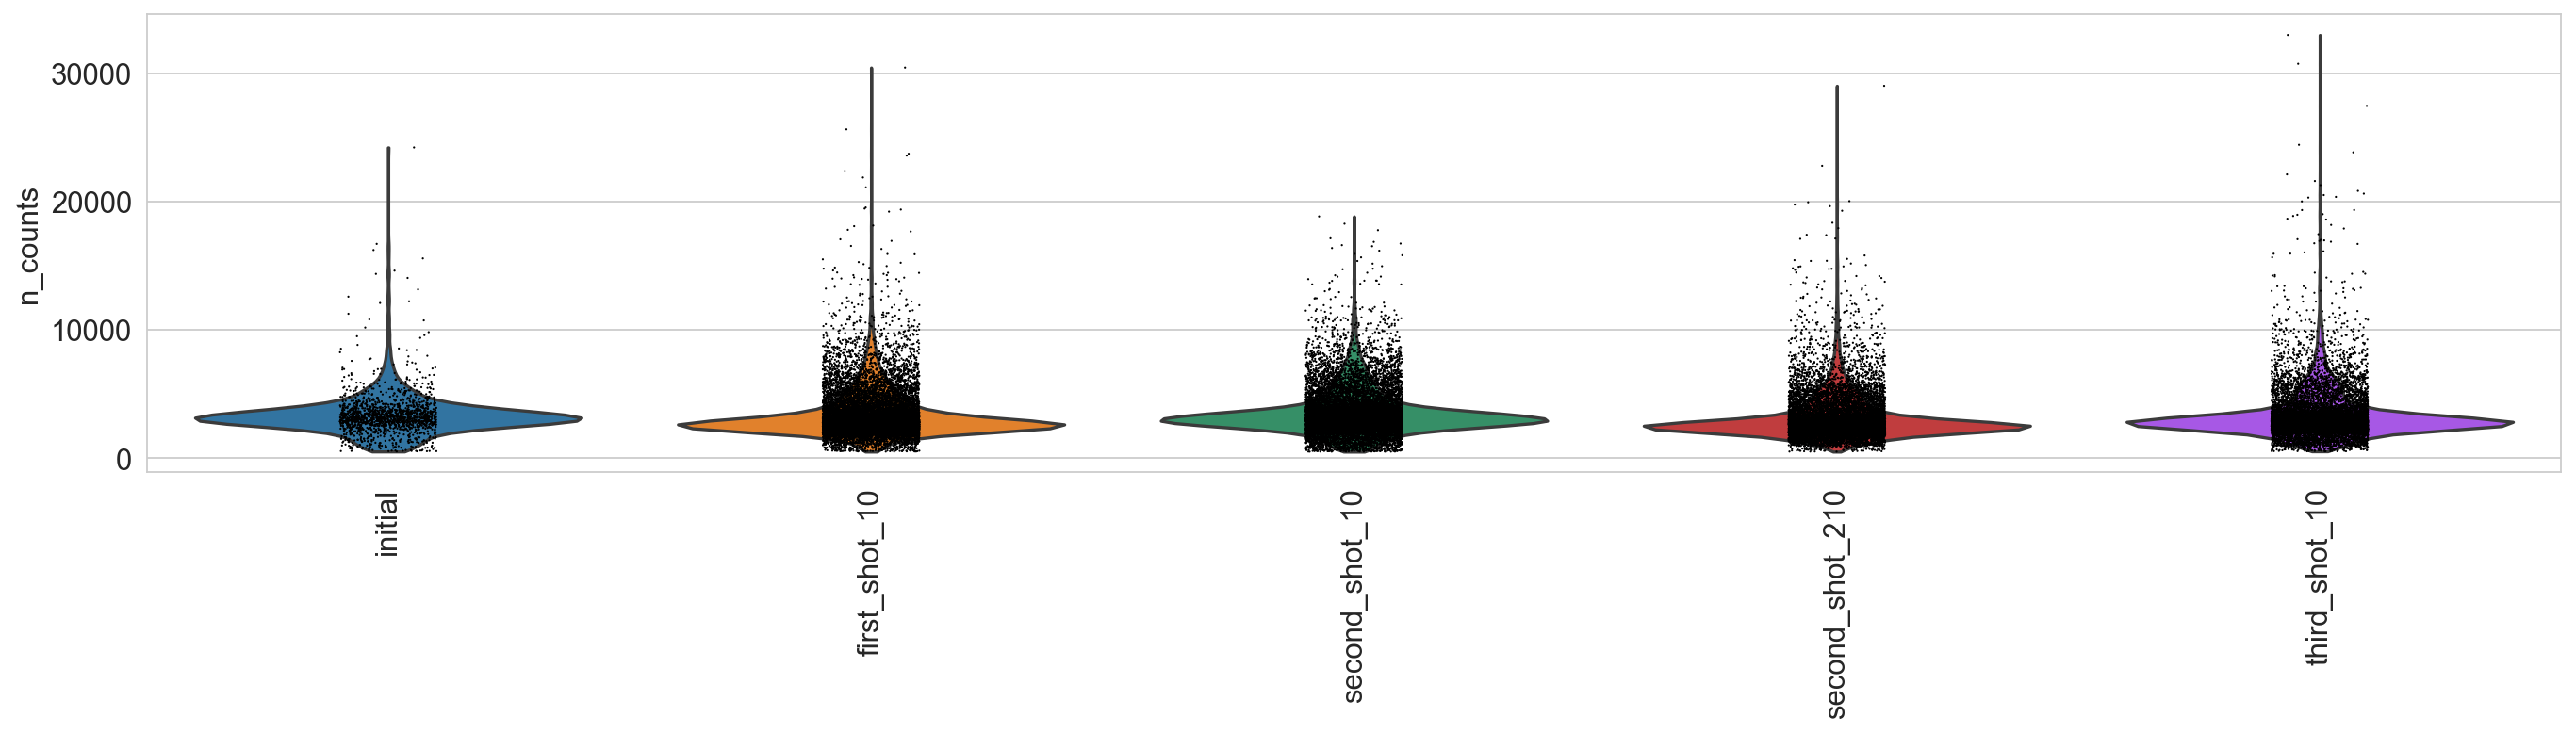

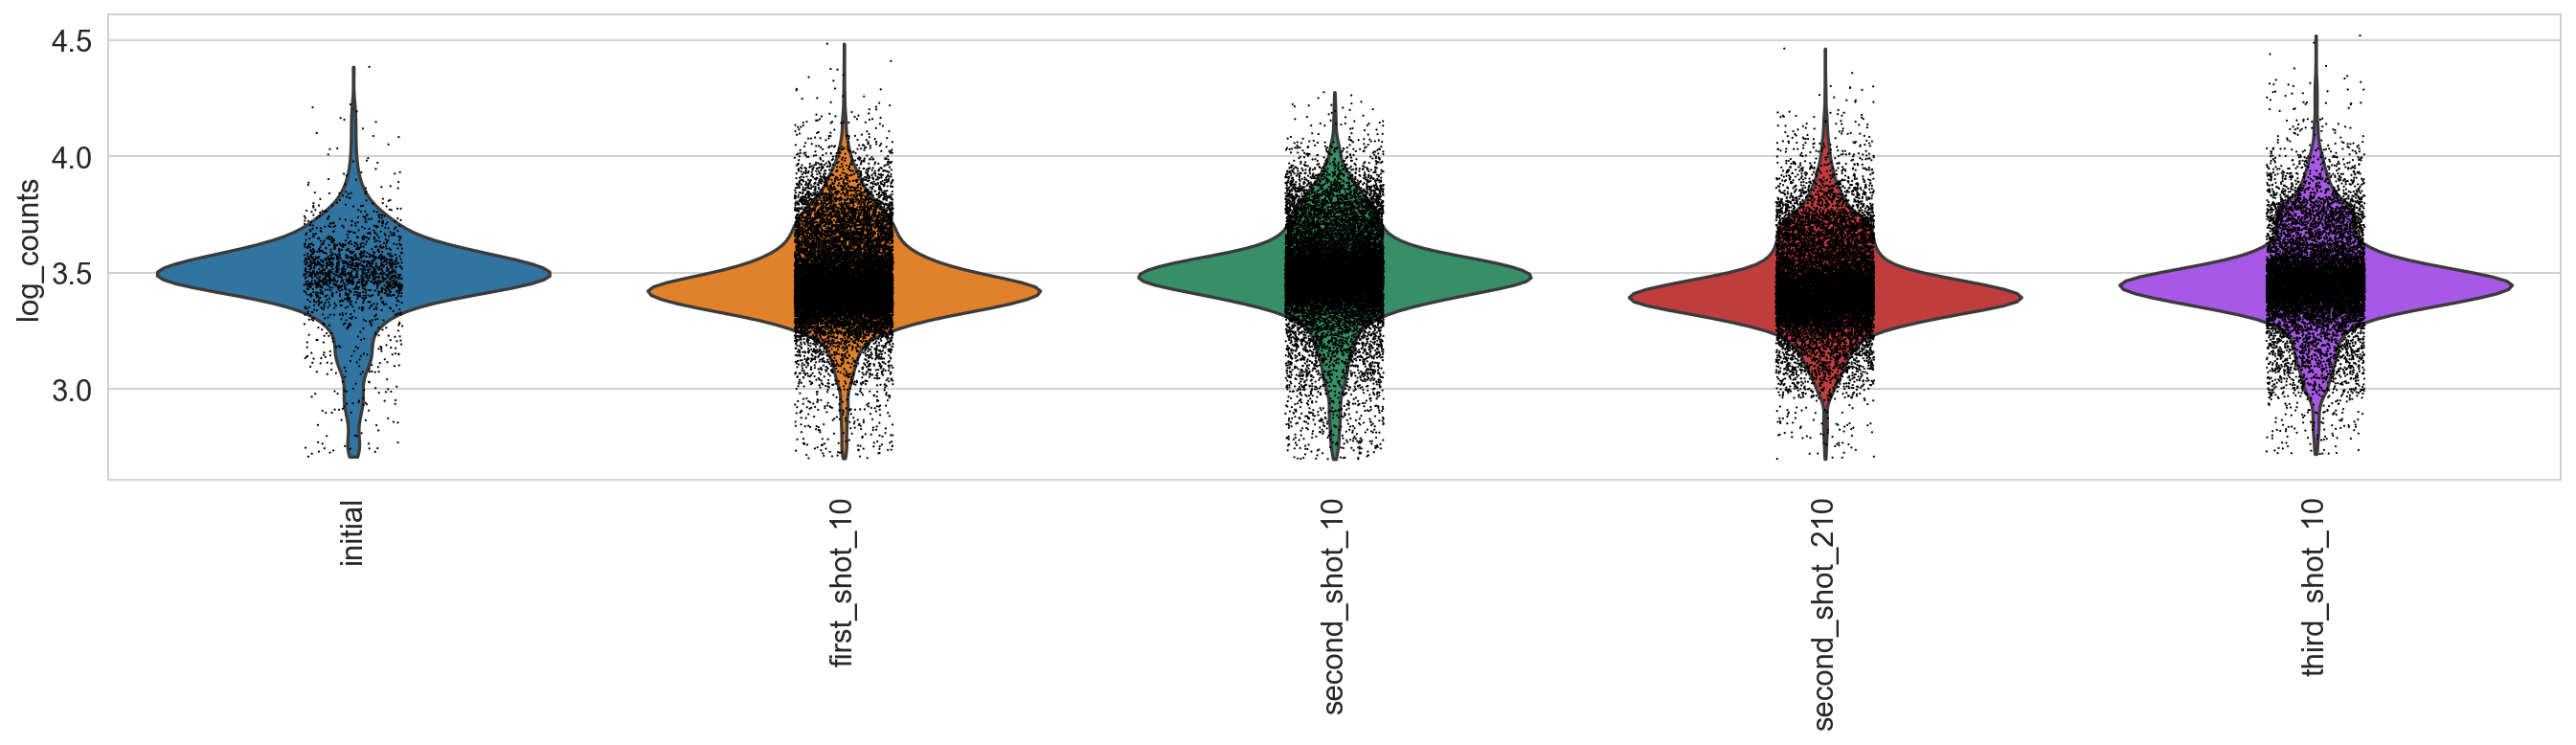

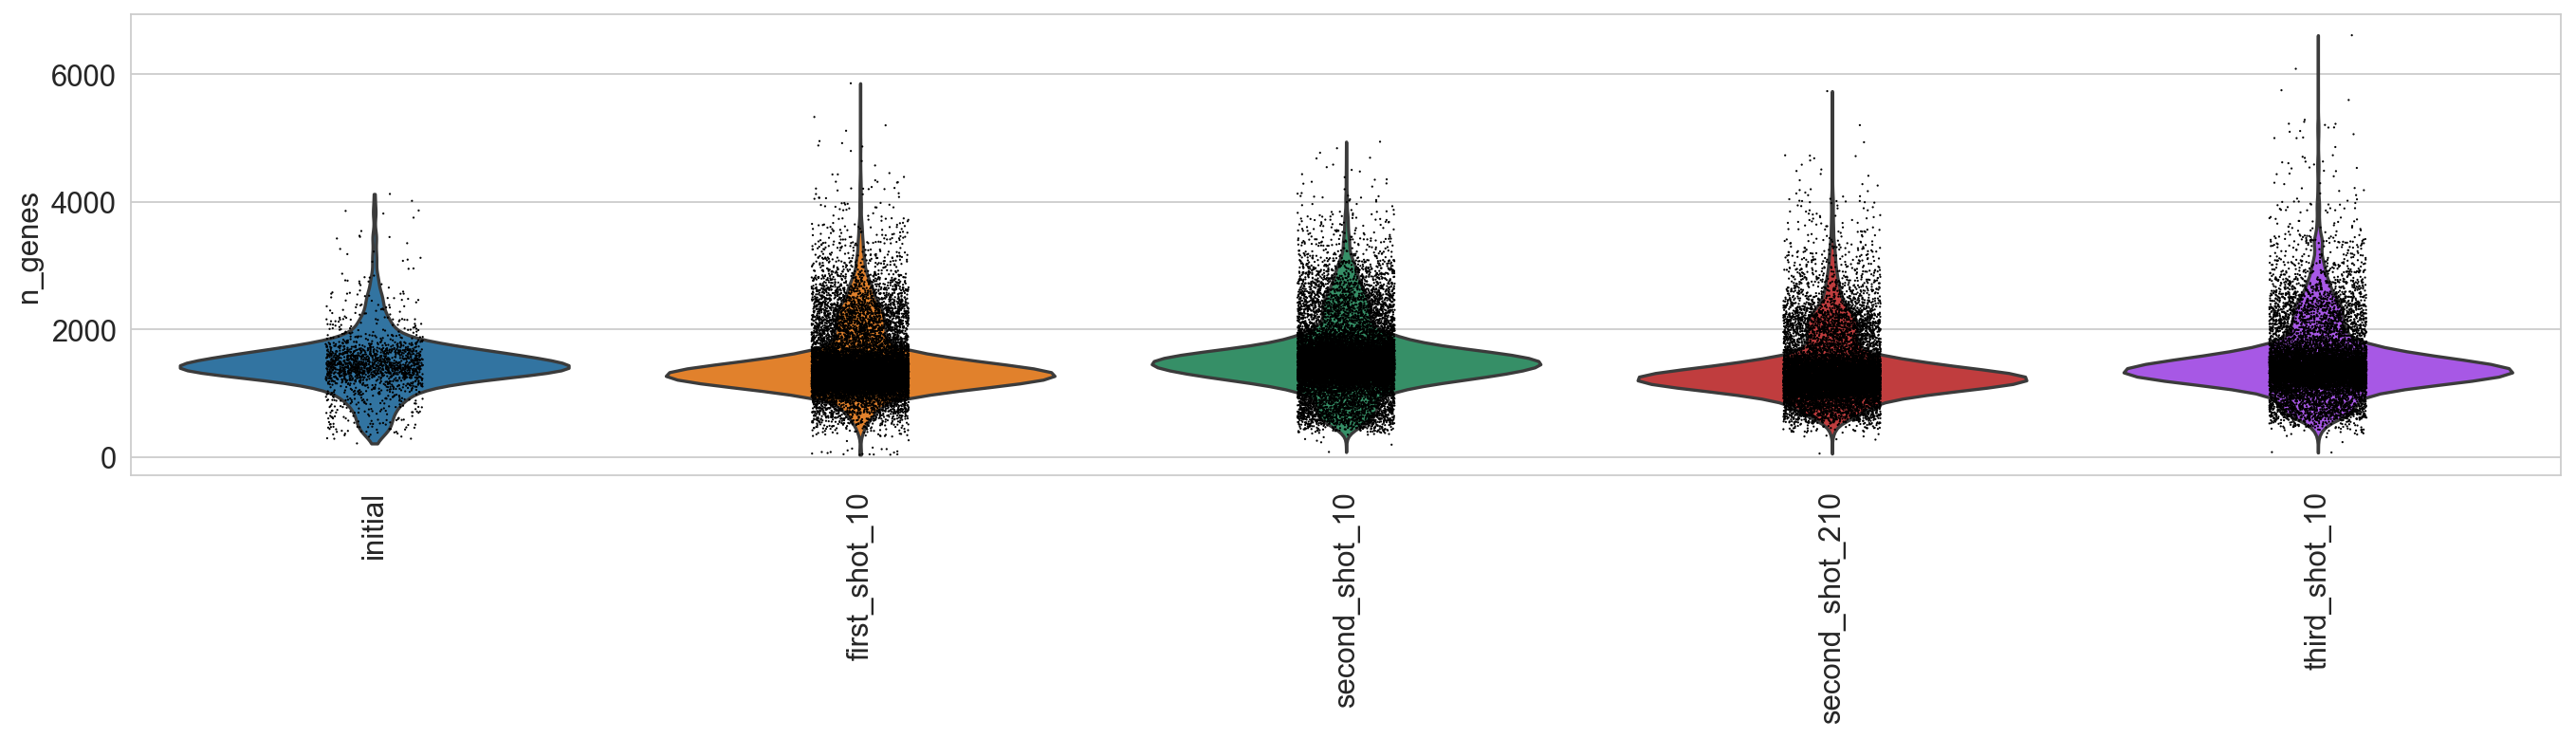

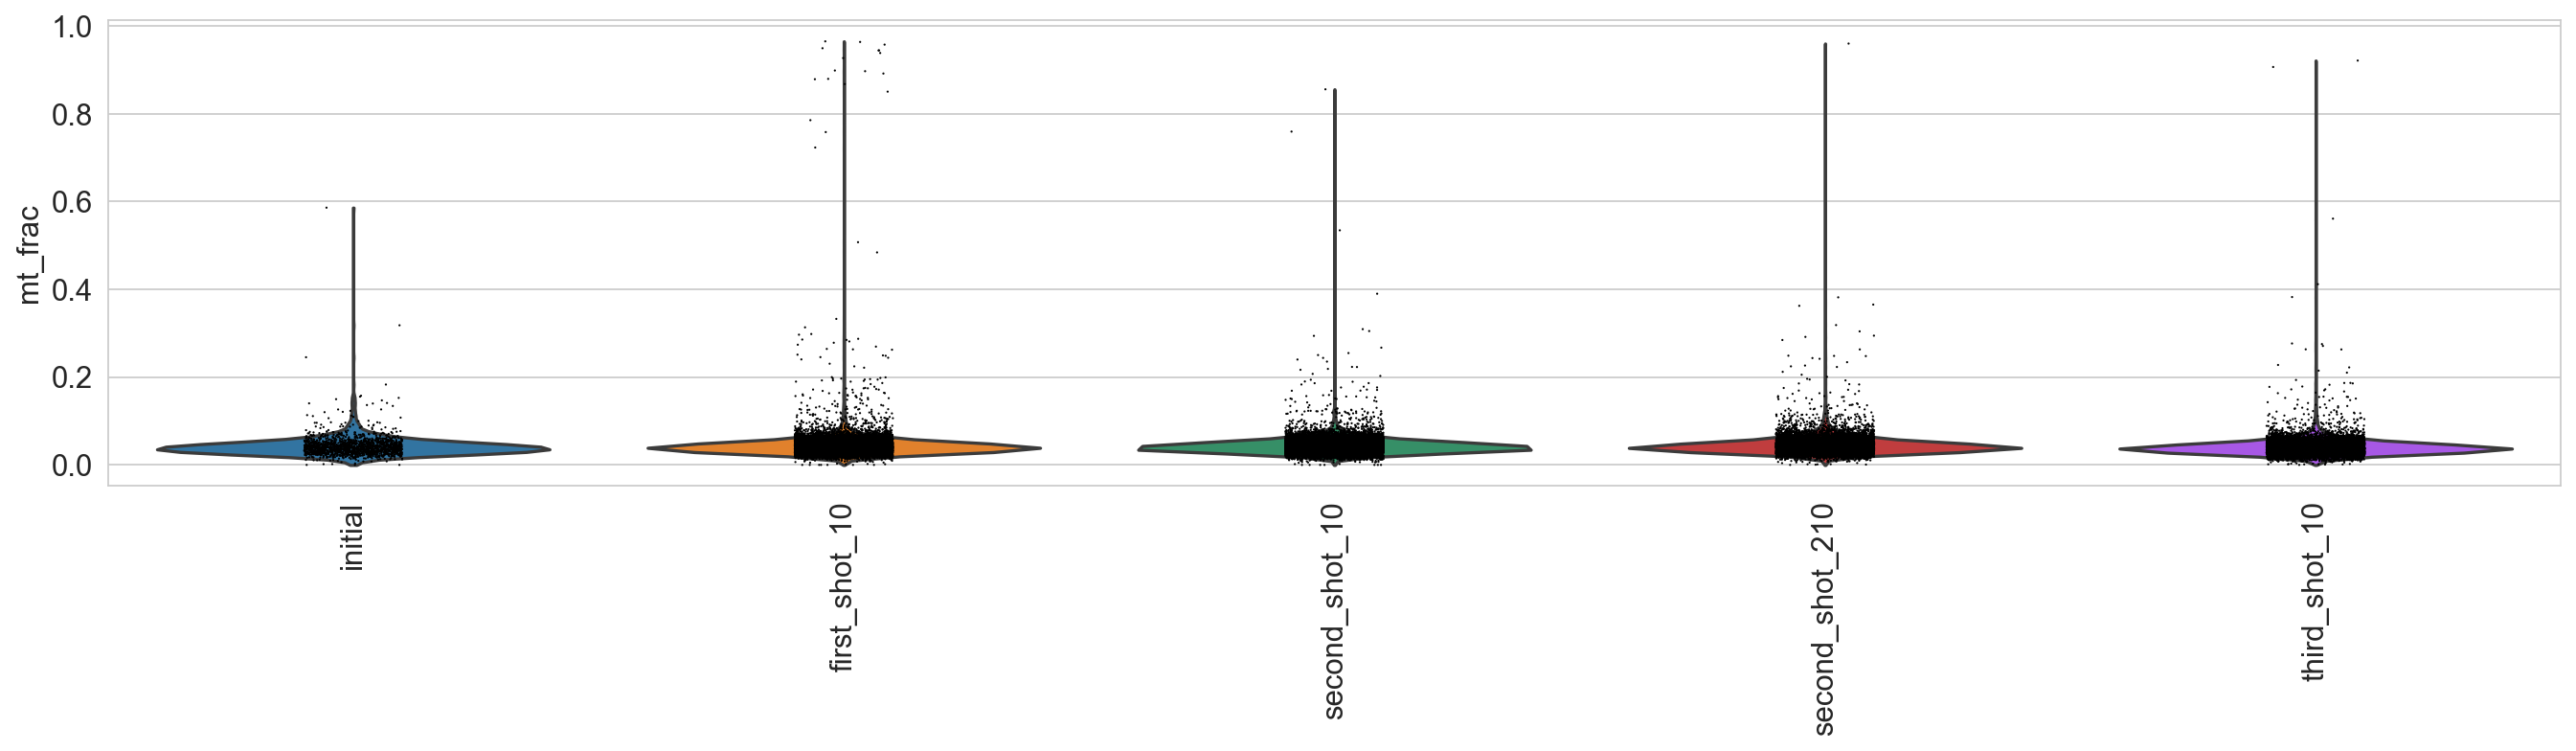

In [10]:
rcParams['figure.figsize'] = (16, 4)
sc.pl.violin(adata, ['n_counts'], size=1, log=False, rotation=90, groupby='sample')
sc.pl.violin(adata, ['log_counts'], size=1, log=False, rotation=90, groupby='sample')
sc.pl.violin(adata, ['n_genes'], size=1, log=False, rotation=90, groupby='sample')
sc.pl.violin(adata, ['mt_frac'], size=1, log=False, rotation=90, groupby='sample')

In [11]:
qc_groups = [
    ['initial'],
    ['first_shot_10'],
    ['second_shot_10'], 
    ['second_shot_210'], 
    ['third_shot_10']    
]

['initial']


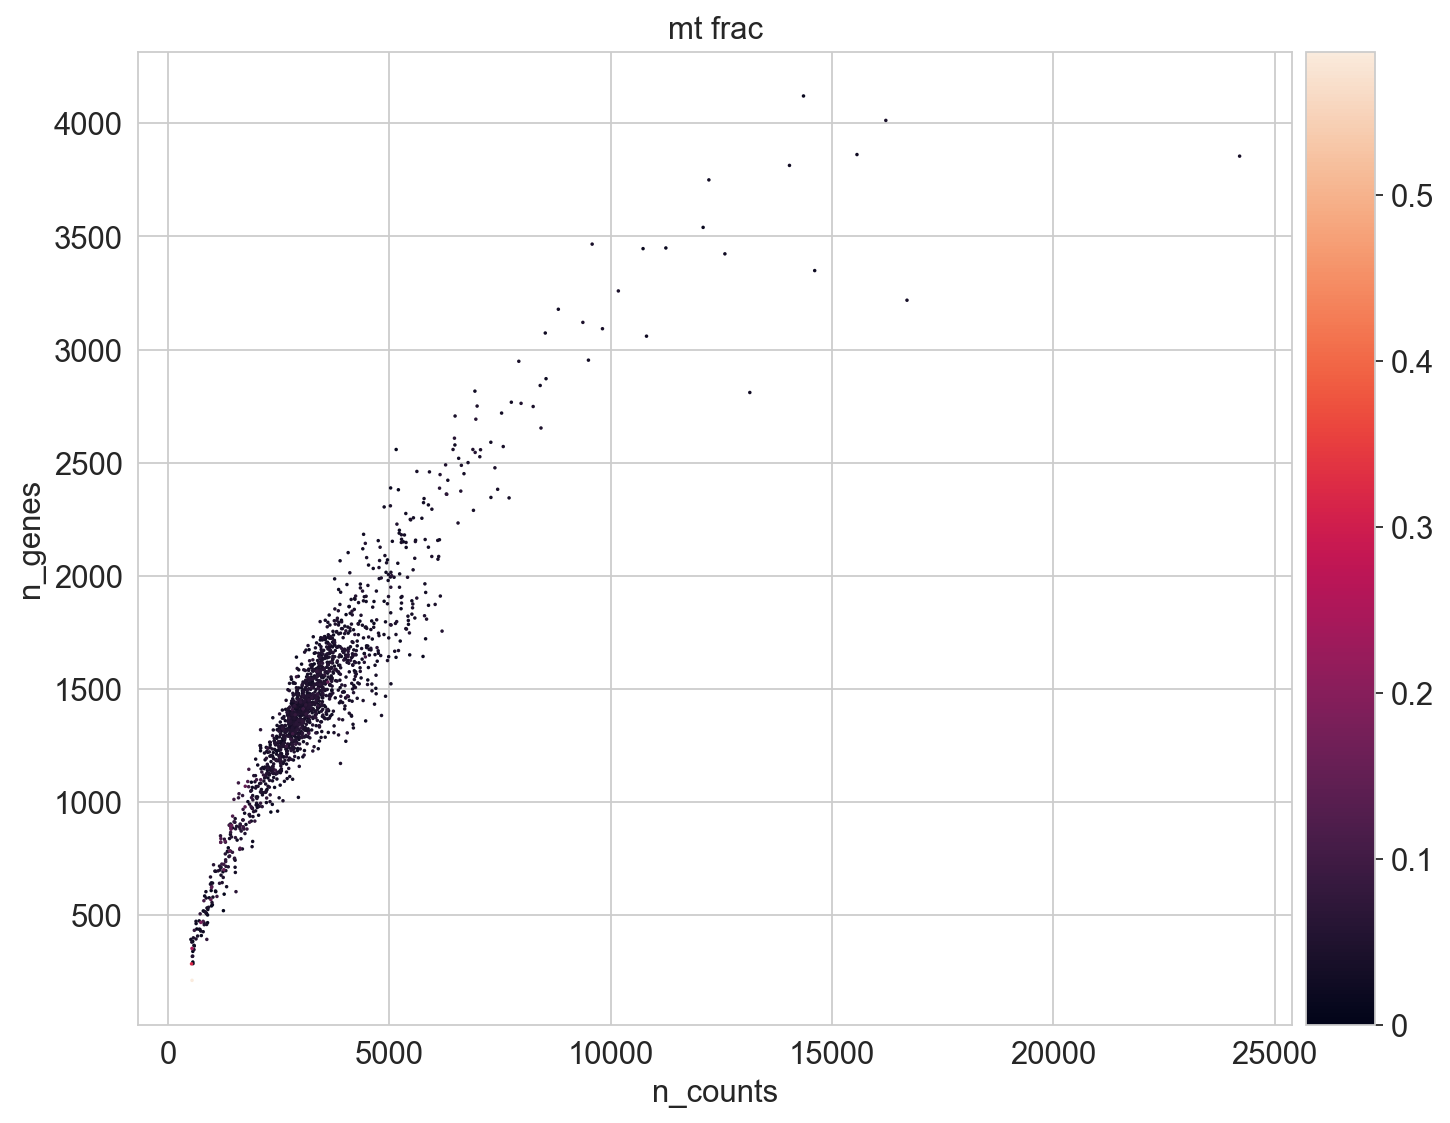

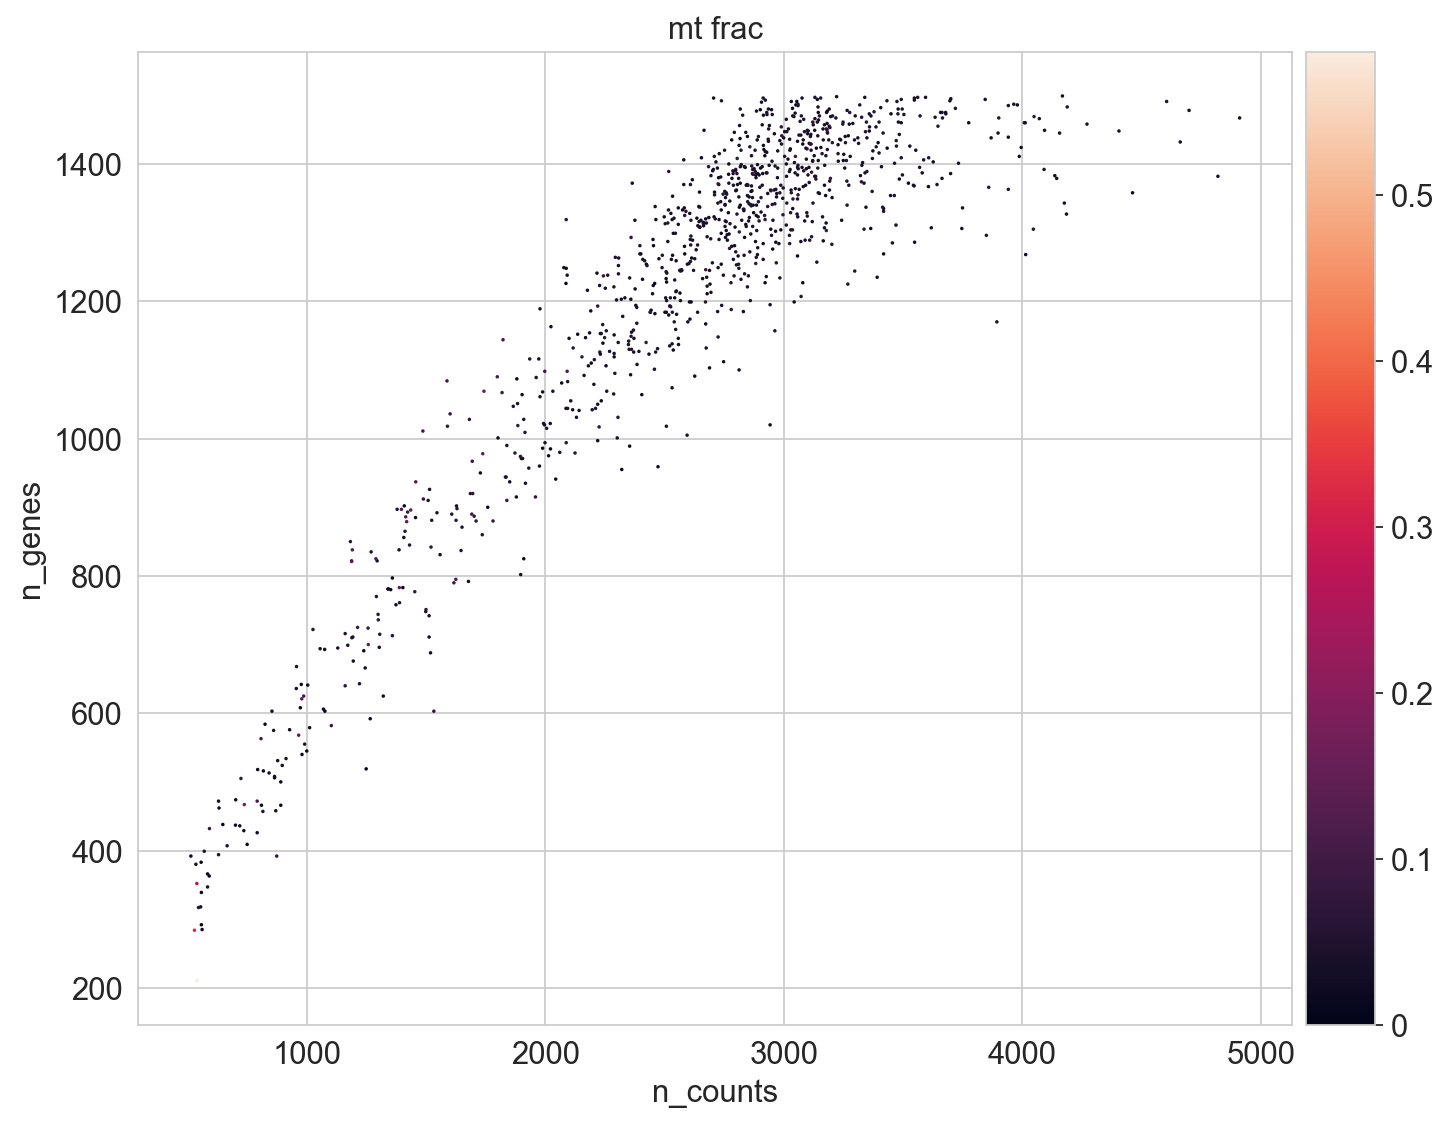

['first_shot_10']


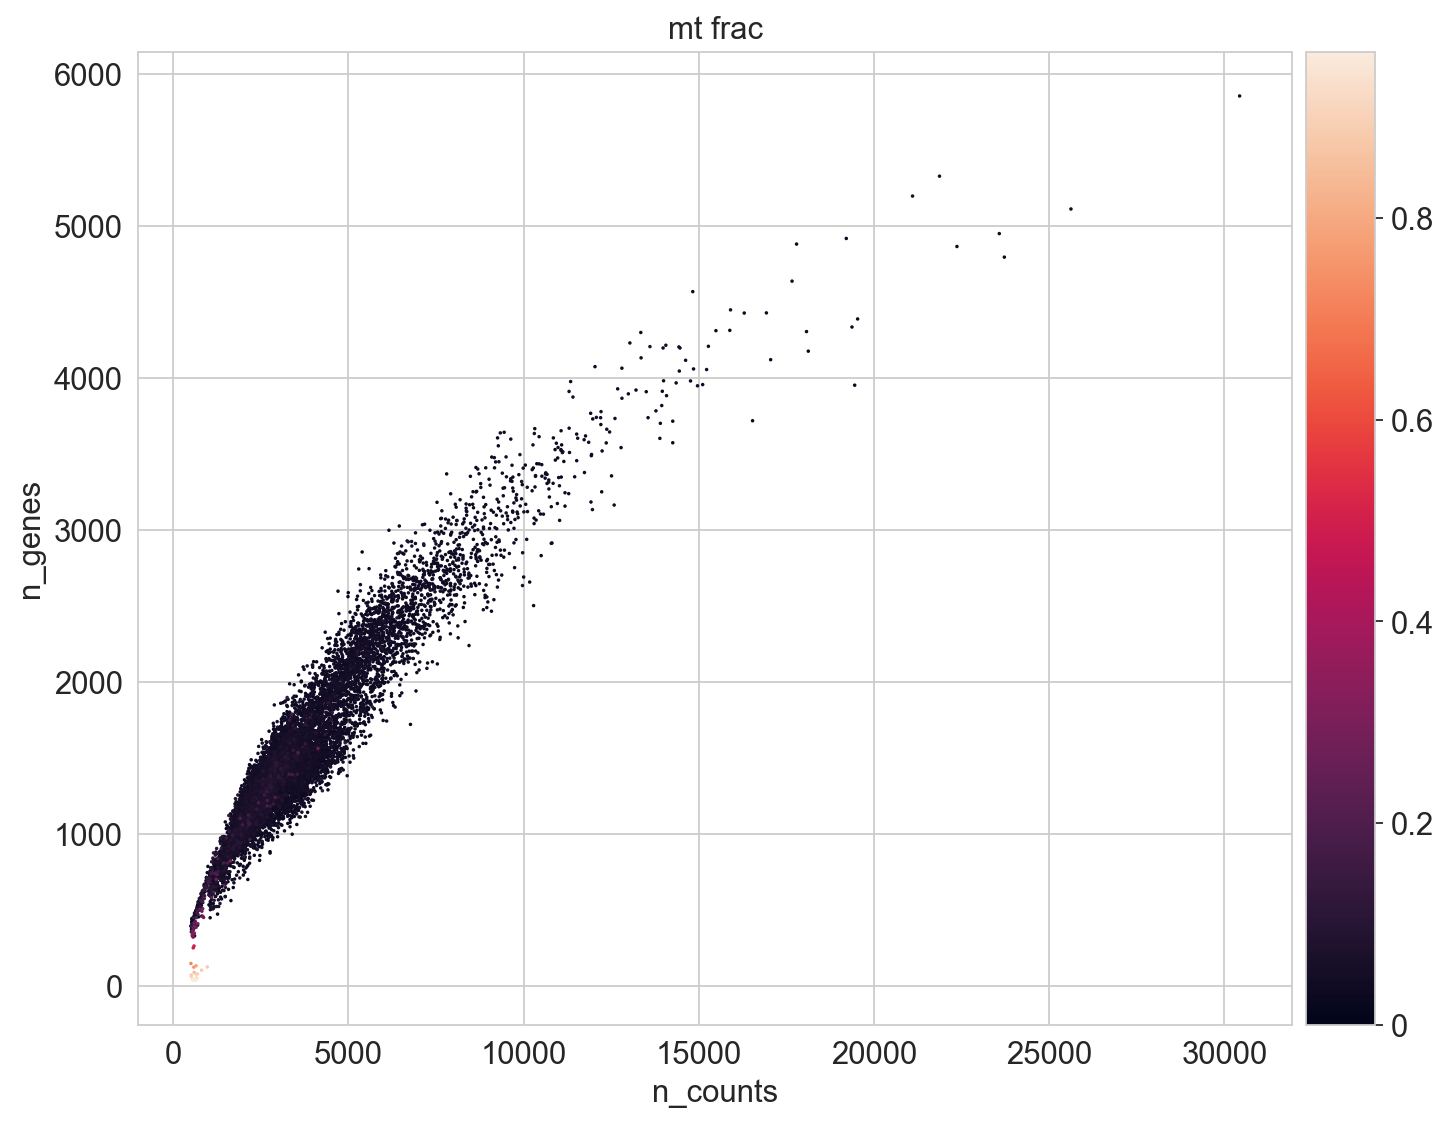

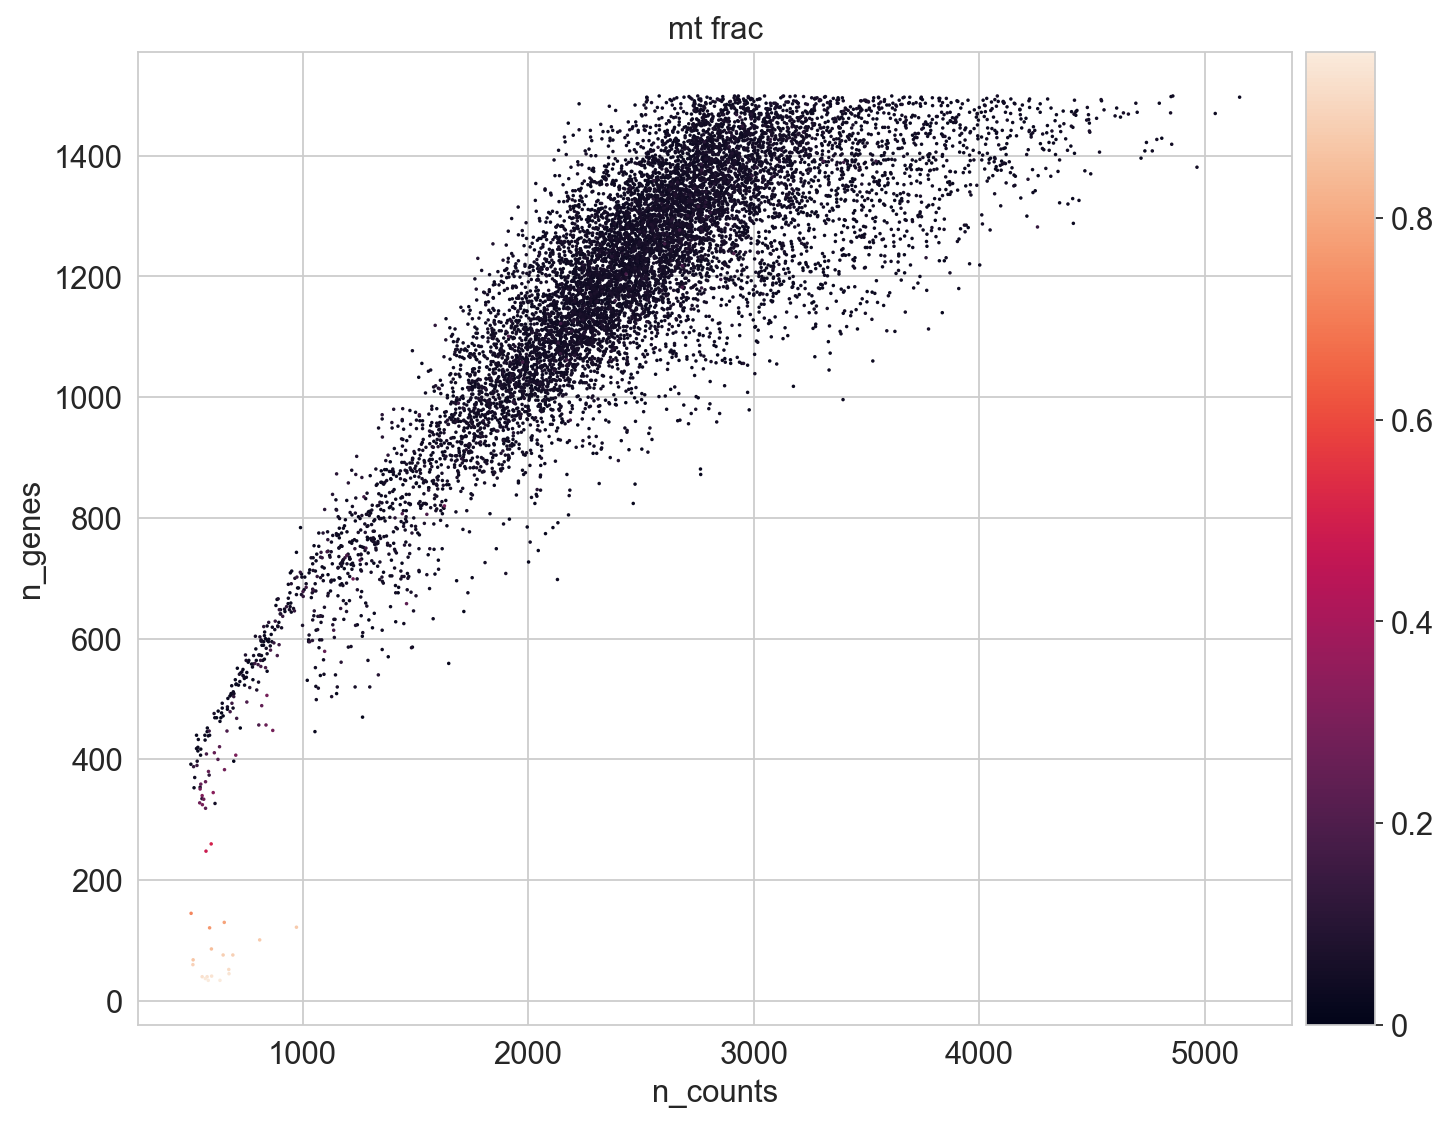

['second_shot_10']


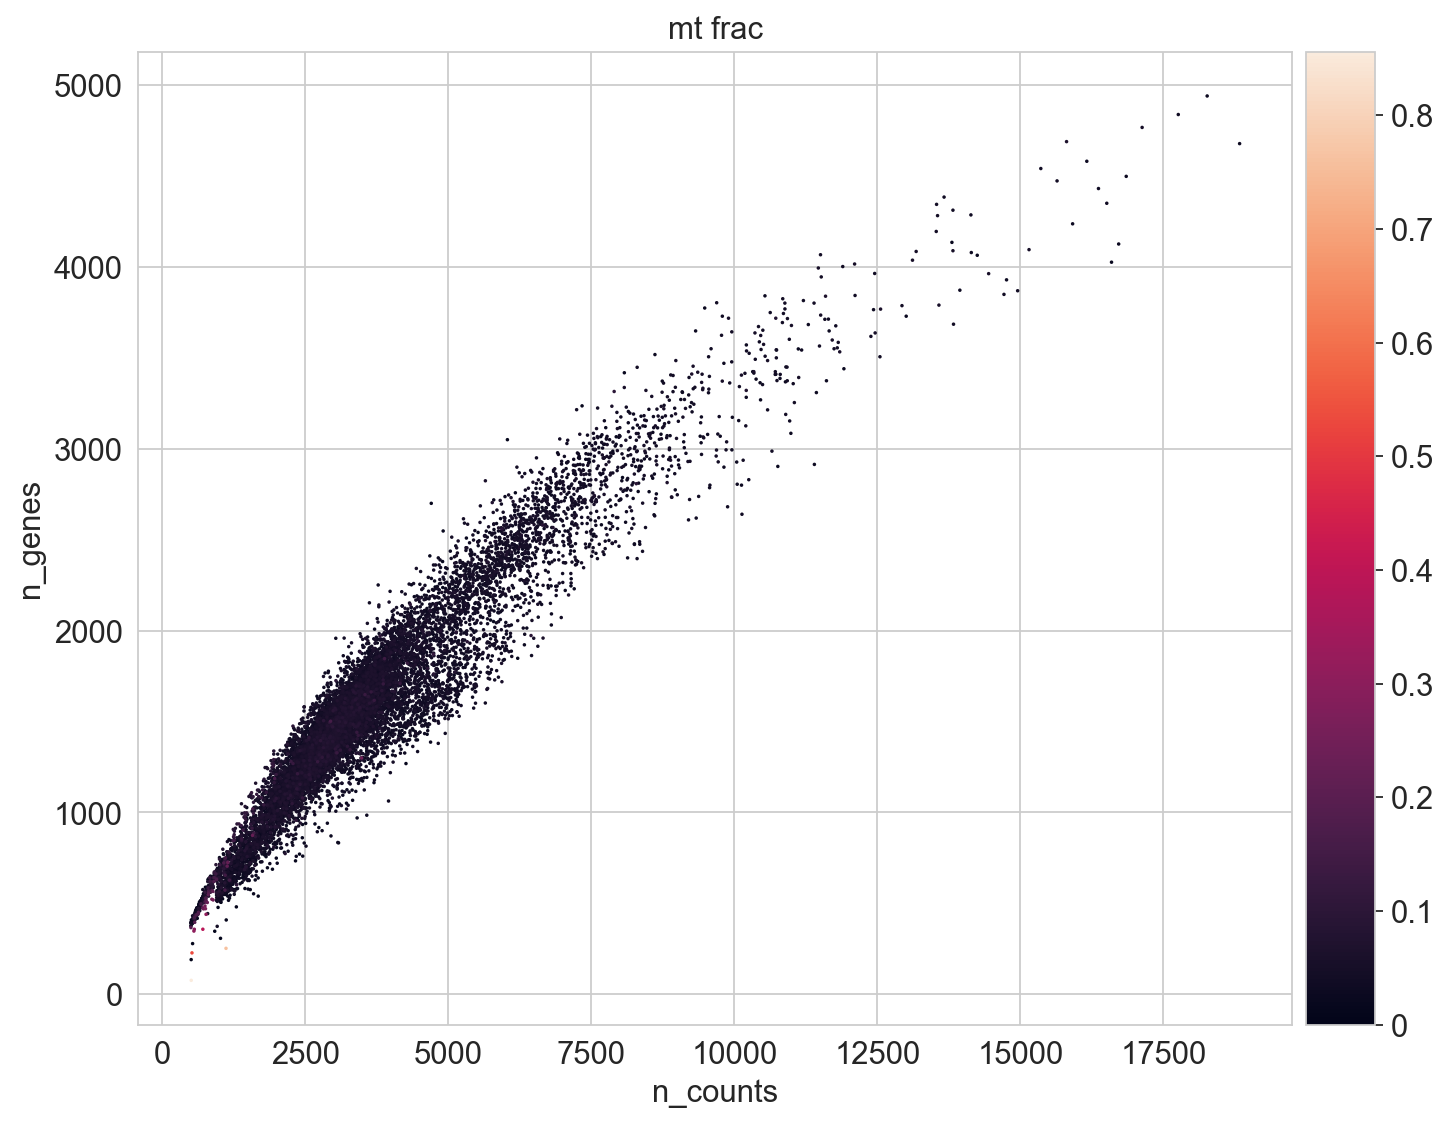

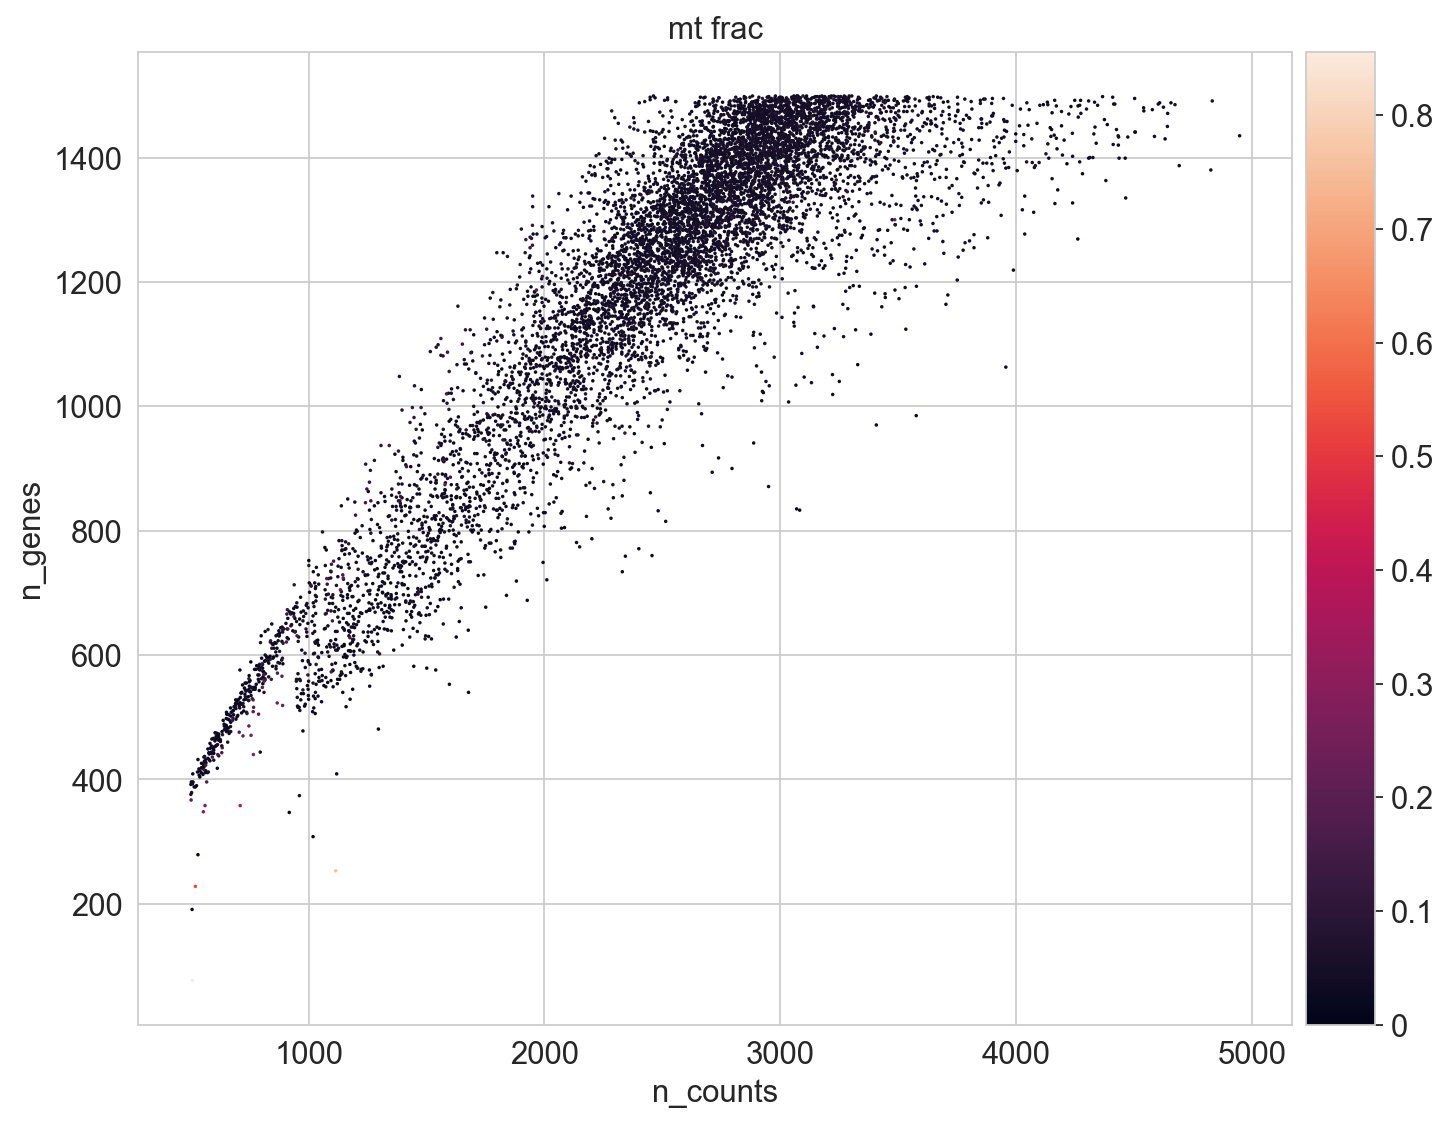

['second_shot_210']


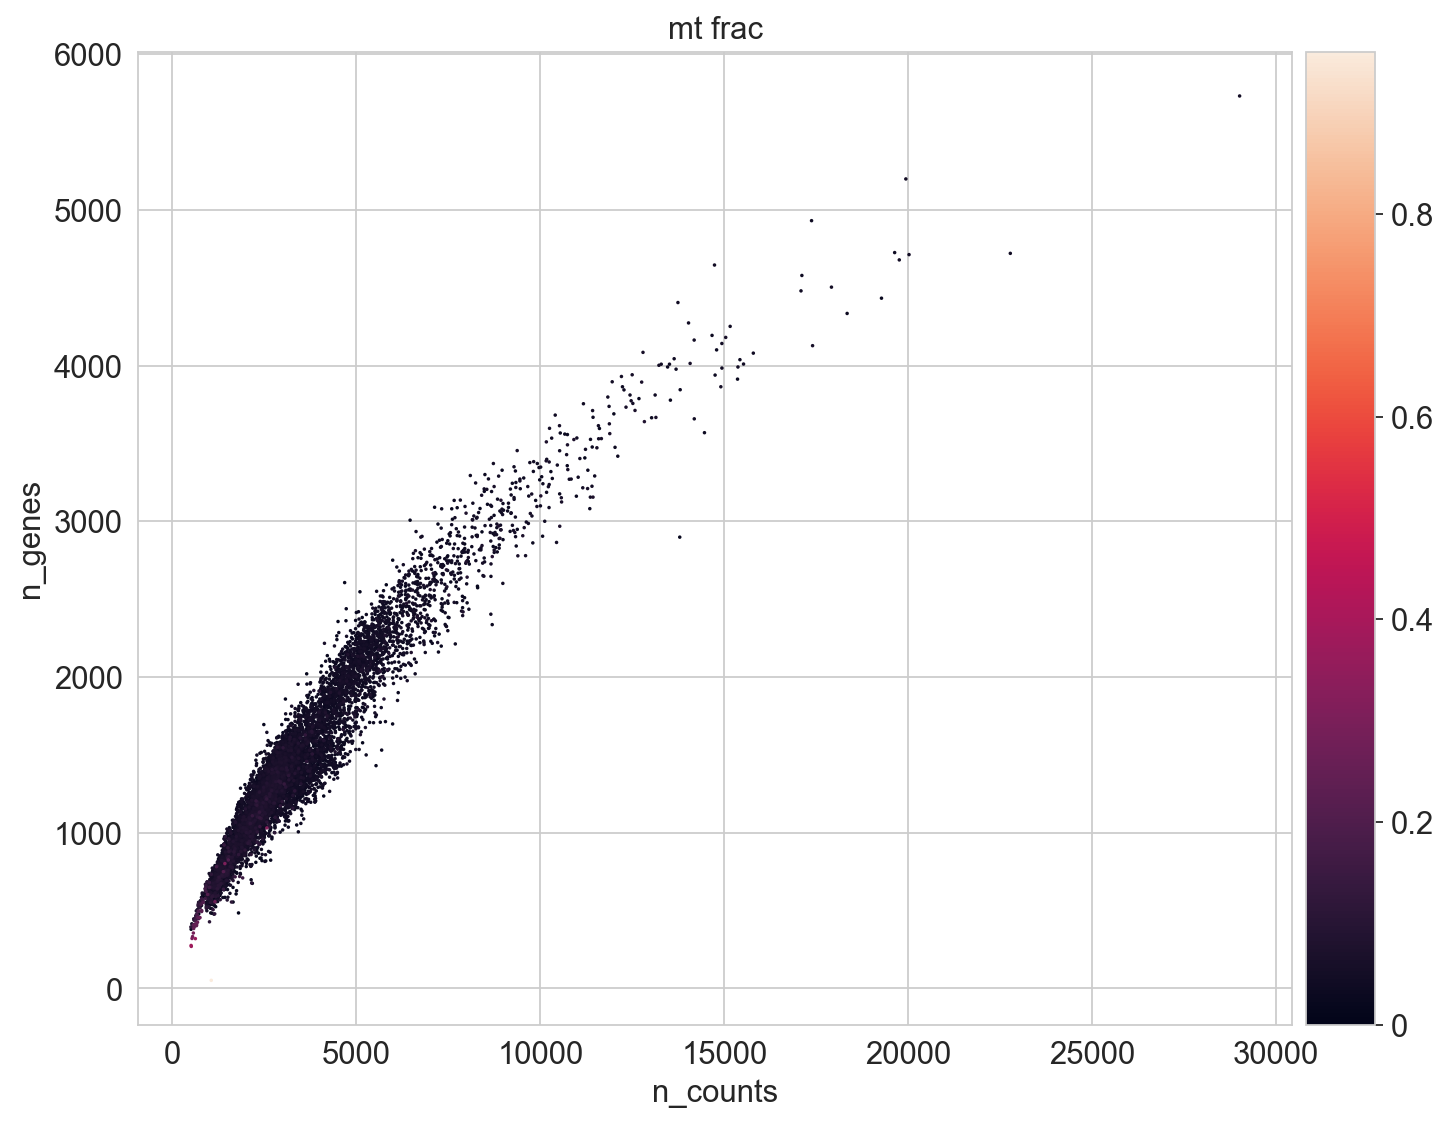

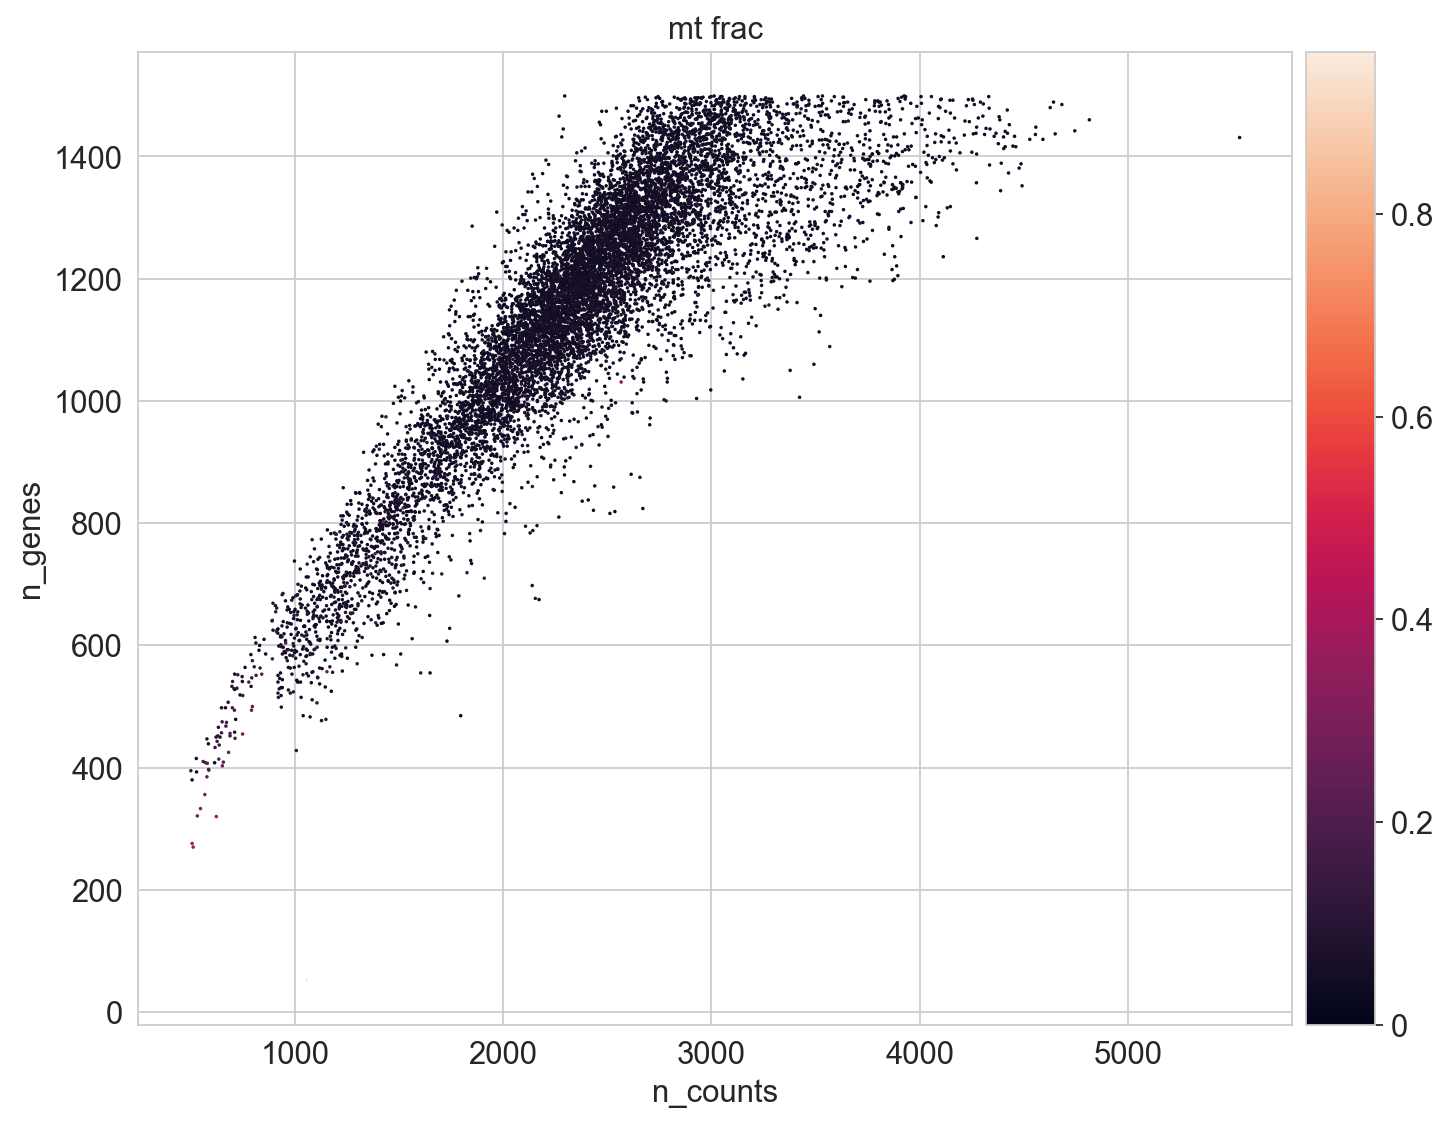

['third_shot_10']


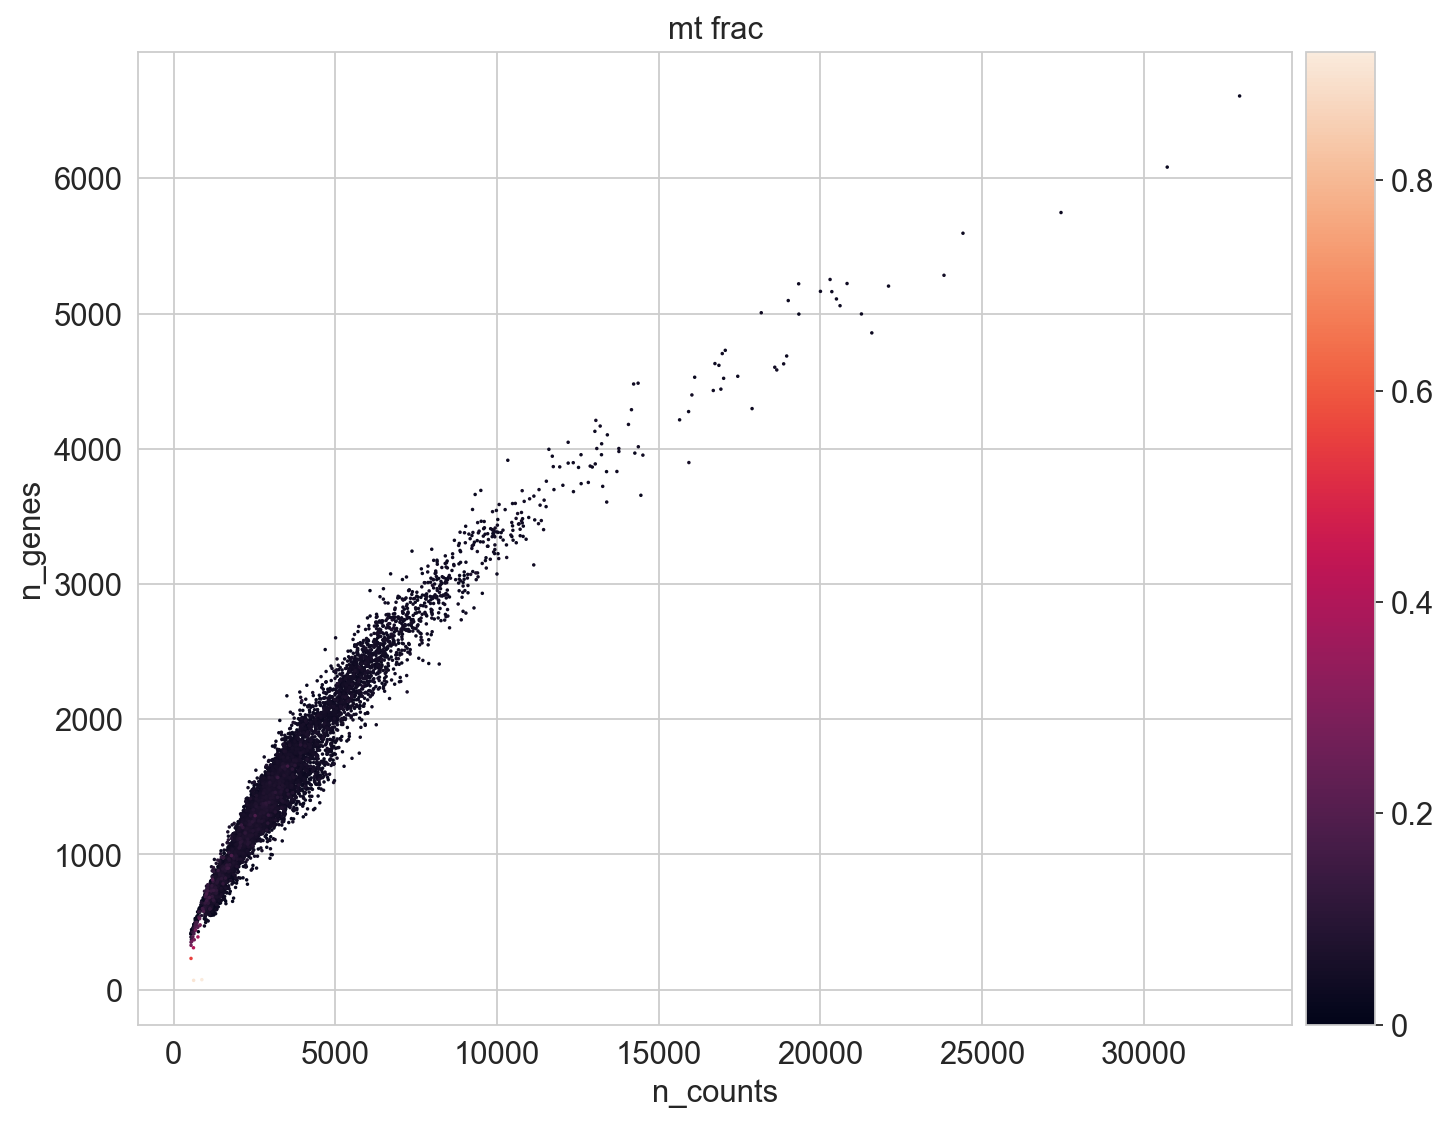

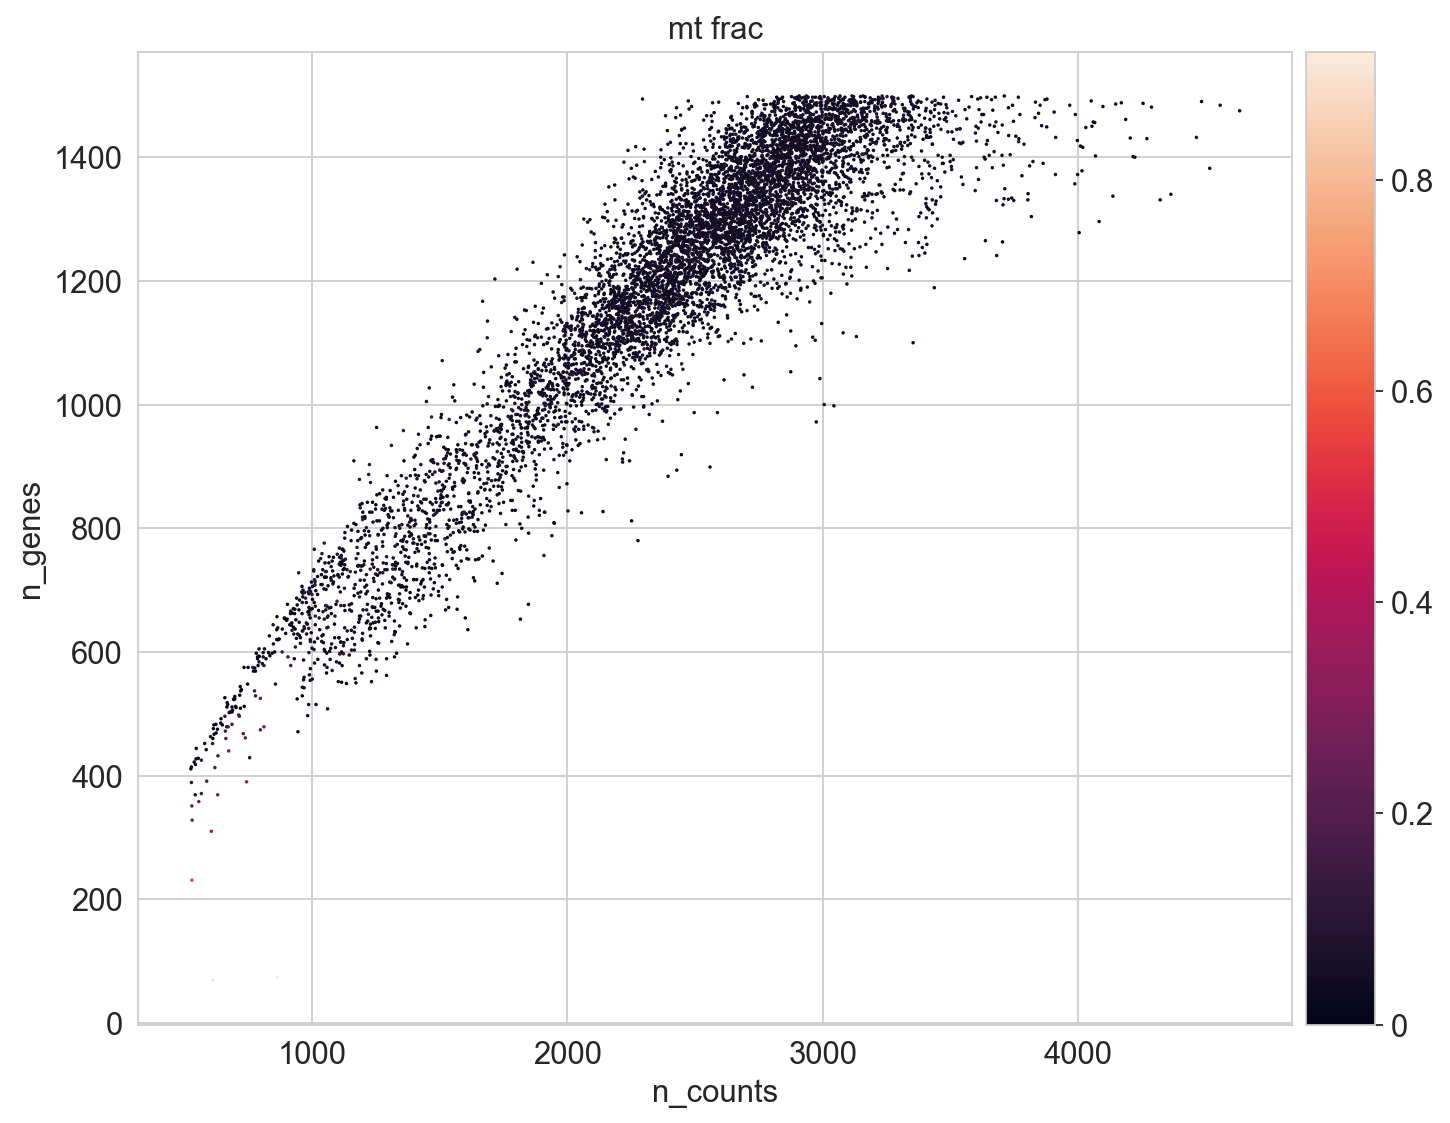

In [12]:
rcParams['figure.figsize'] = (8, 8)
for g in qc_groups:
    print(g)
    adata_tmp = adata[adata.obs['sample'].isin(g)]
    sc.pl.scatter(adata_tmp, y='n_genes', x='n_counts', color ='mt_frac', size=10, show=False)
    sc.pl.scatter(adata_tmp[np.logical_and(adata_tmp.obs['n_genes']<1500, adata_tmp.obs['n_counts']<8000)],
             y='n_genes', x='n_counts', color='mt_frac', size=10, show=False)
    plt.show()

### Apply Filtering

In [13]:
params_filter = [
    {   'mt_frac': 0.1,
        'n_counts_min': 1000,
        'n_counts_max': 7000,
        'n_genes_min': 1000,
    },
    {   'mt_frac': 0.1,
        'n_counts_min': 1500,
        'n_counts_max': 9500,
        'n_genes_min': 800,
    },
    {   'mt_frac': 0.1,
        'n_counts_min': 1300,
        'n_counts_max': 8000,
        'n_genes_min': 700,
    },
    {   'mt_frac': 0.1,
        'n_counts_min': 1200,
        'n_counts_max': 8000,
        'n_genes_min': 700,
    },    
    {   'mt_frac': 0.1,
        'n_counts_min': 1100,
        'n_counts_max': 9000,
        'n_genes_min': 650,
    },
]

In [14]:
adatas = []

for i, g in enumerate(qc_groups):
    adata_tmp = adata[adata.obs['sample'].isin(g)]
    params = params_filter[i]
    
    print(f'Size of Group {i} before filtering: {len(adata_tmp)}')
    adata_tmp = adata_tmp[adata_tmp.obs['mt_frac'] < params['mt_frac']]
    adata_tmp = adata_tmp[adata_tmp.obs['n_counts'] > params['n_counts_min']]
    adata_tmp = adata_tmp[adata_tmp.obs['n_counts'] < params['n_counts_max']]
    adata_tmp = adata_tmp[adata_tmp.obs['n_genes'] > params['n_genes_min']]
    print(f'Size of Group {i} after filtering: {len(adata_tmp)}')
    print('')
    adatas.append(adata_tmp)
    
adata = adatas[0].concatenate(adatas[1:])
sc.pp.filter_genes(adata, min_cells=10)
adata.shape

Size of Group 0 before filtering: 1604
Size of Group 0 after filtering: 1383

Size of Group 1 before filtering: 14840
Size of Group 1 after filtering: 13896

Size of Group 2 before filtering: 15385
Size of Group 2 after filtering: 14172

Size of Group 3 before filtering: 13407
Size of Group 3 after filtering: 12581

Size of Group 4 before filtering: 11222
Size of Group 4 after filtering: 10633

filtered out 18128 genes that are detected in less than 10 cells


(52665, 18473)

## QC after filtering

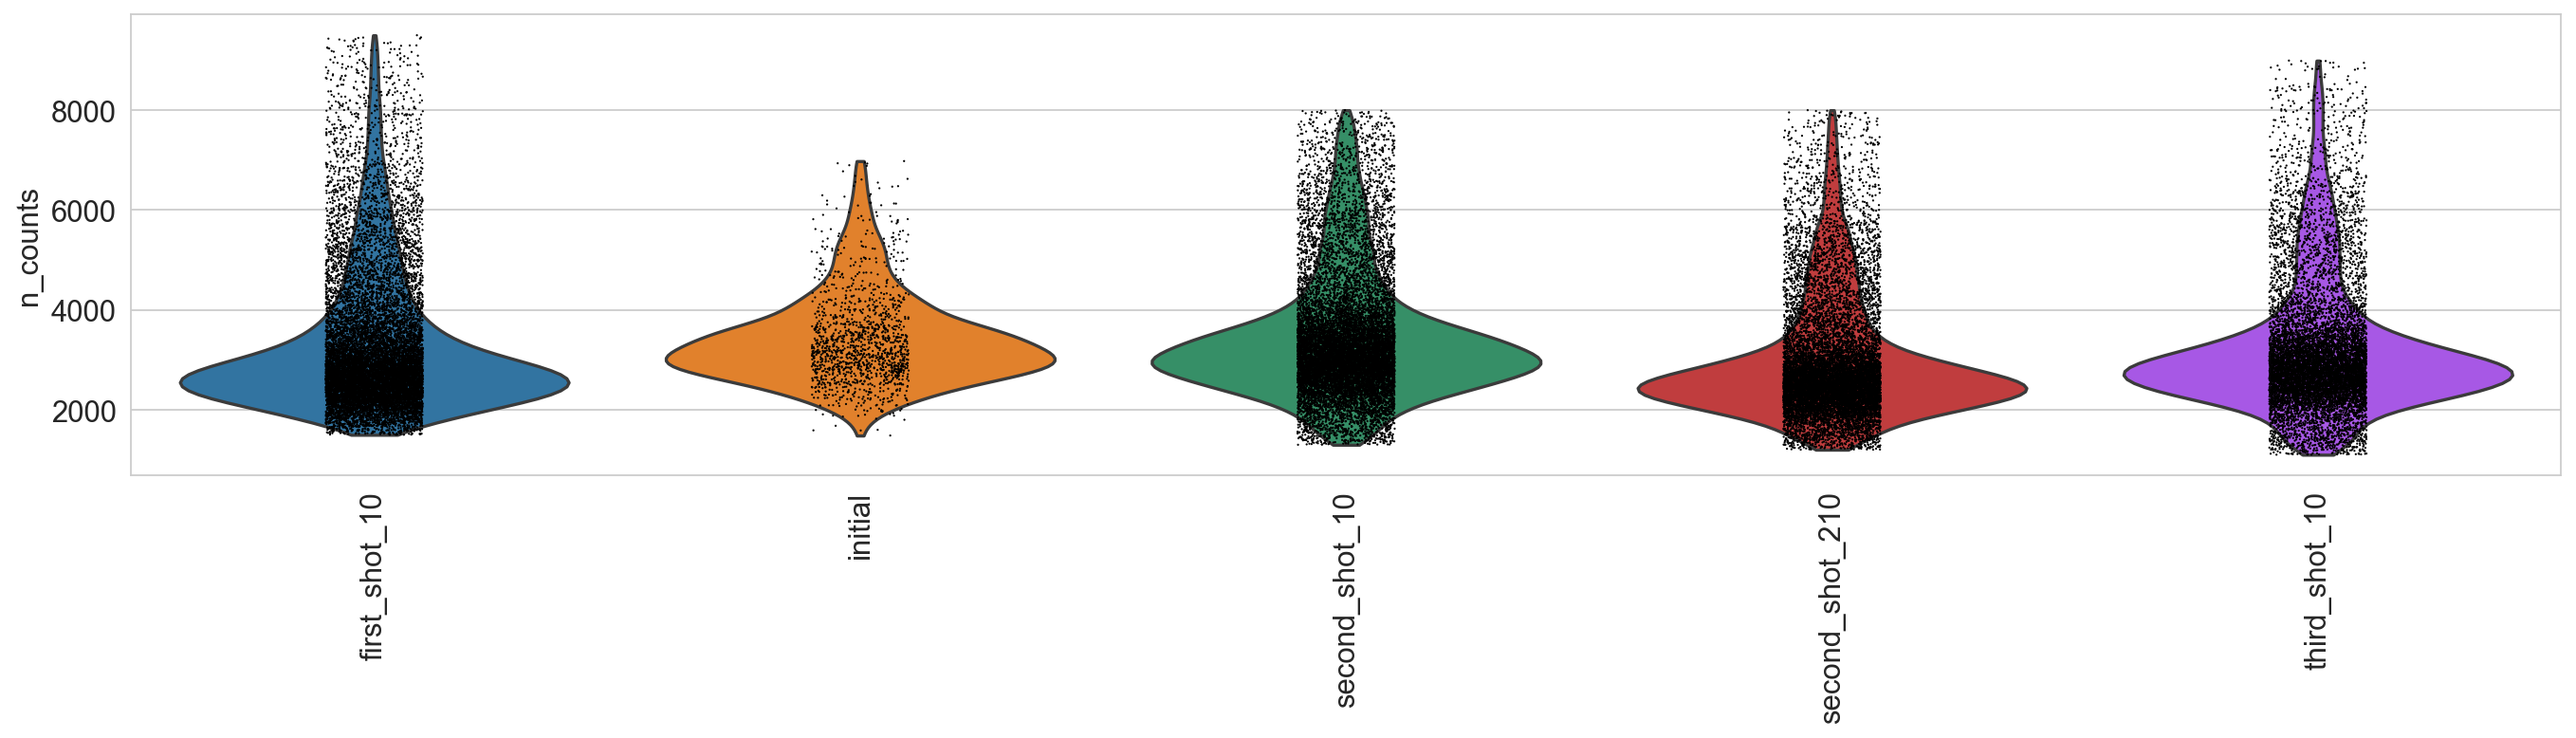

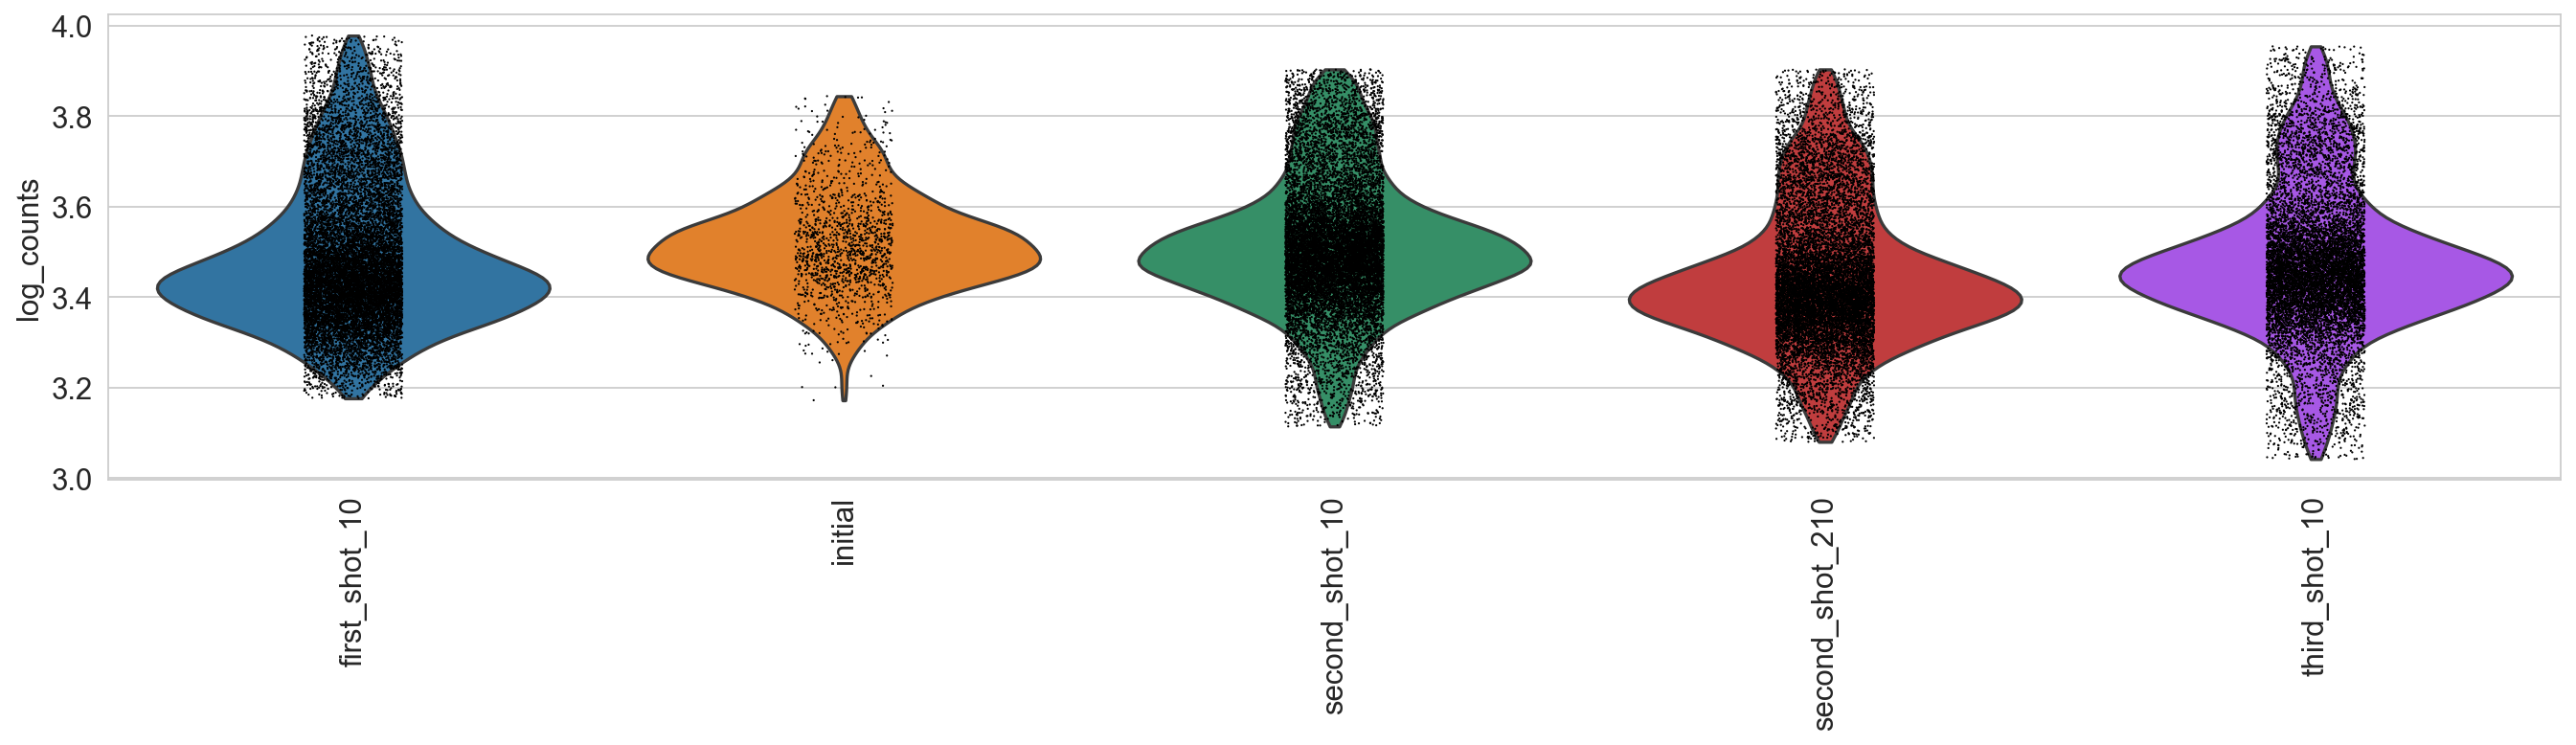

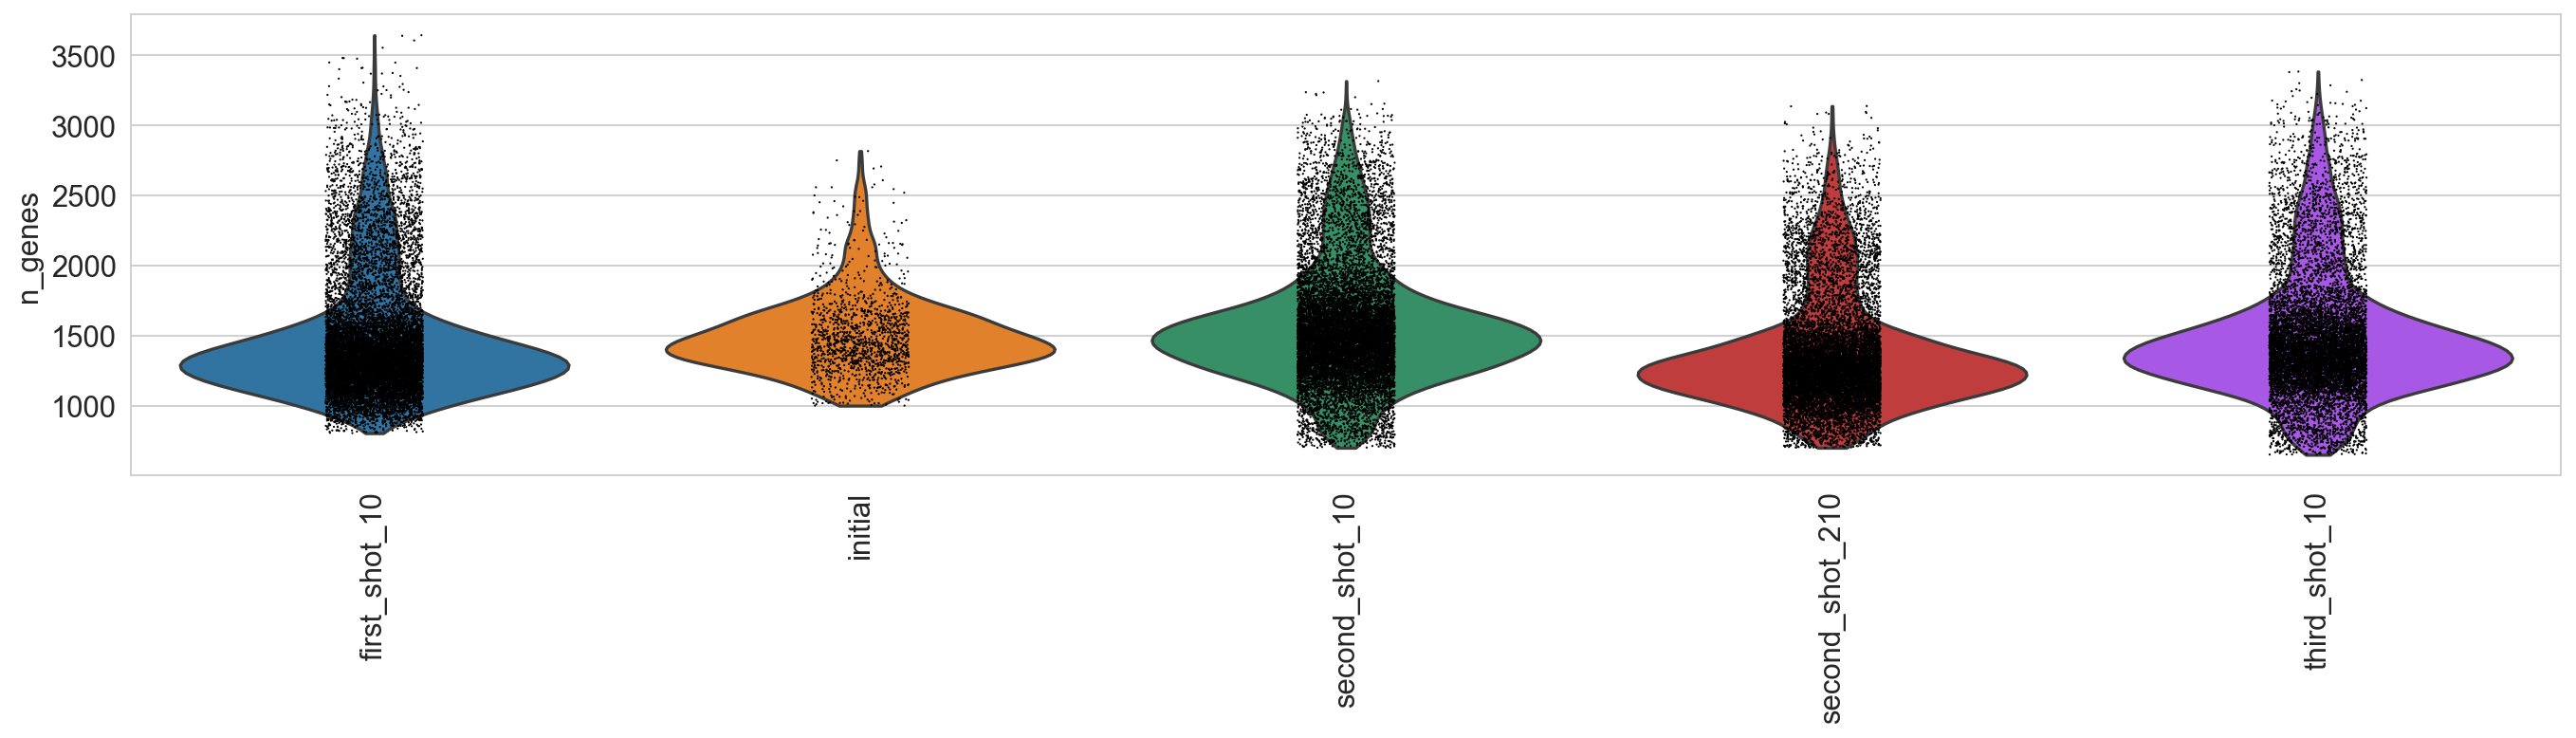

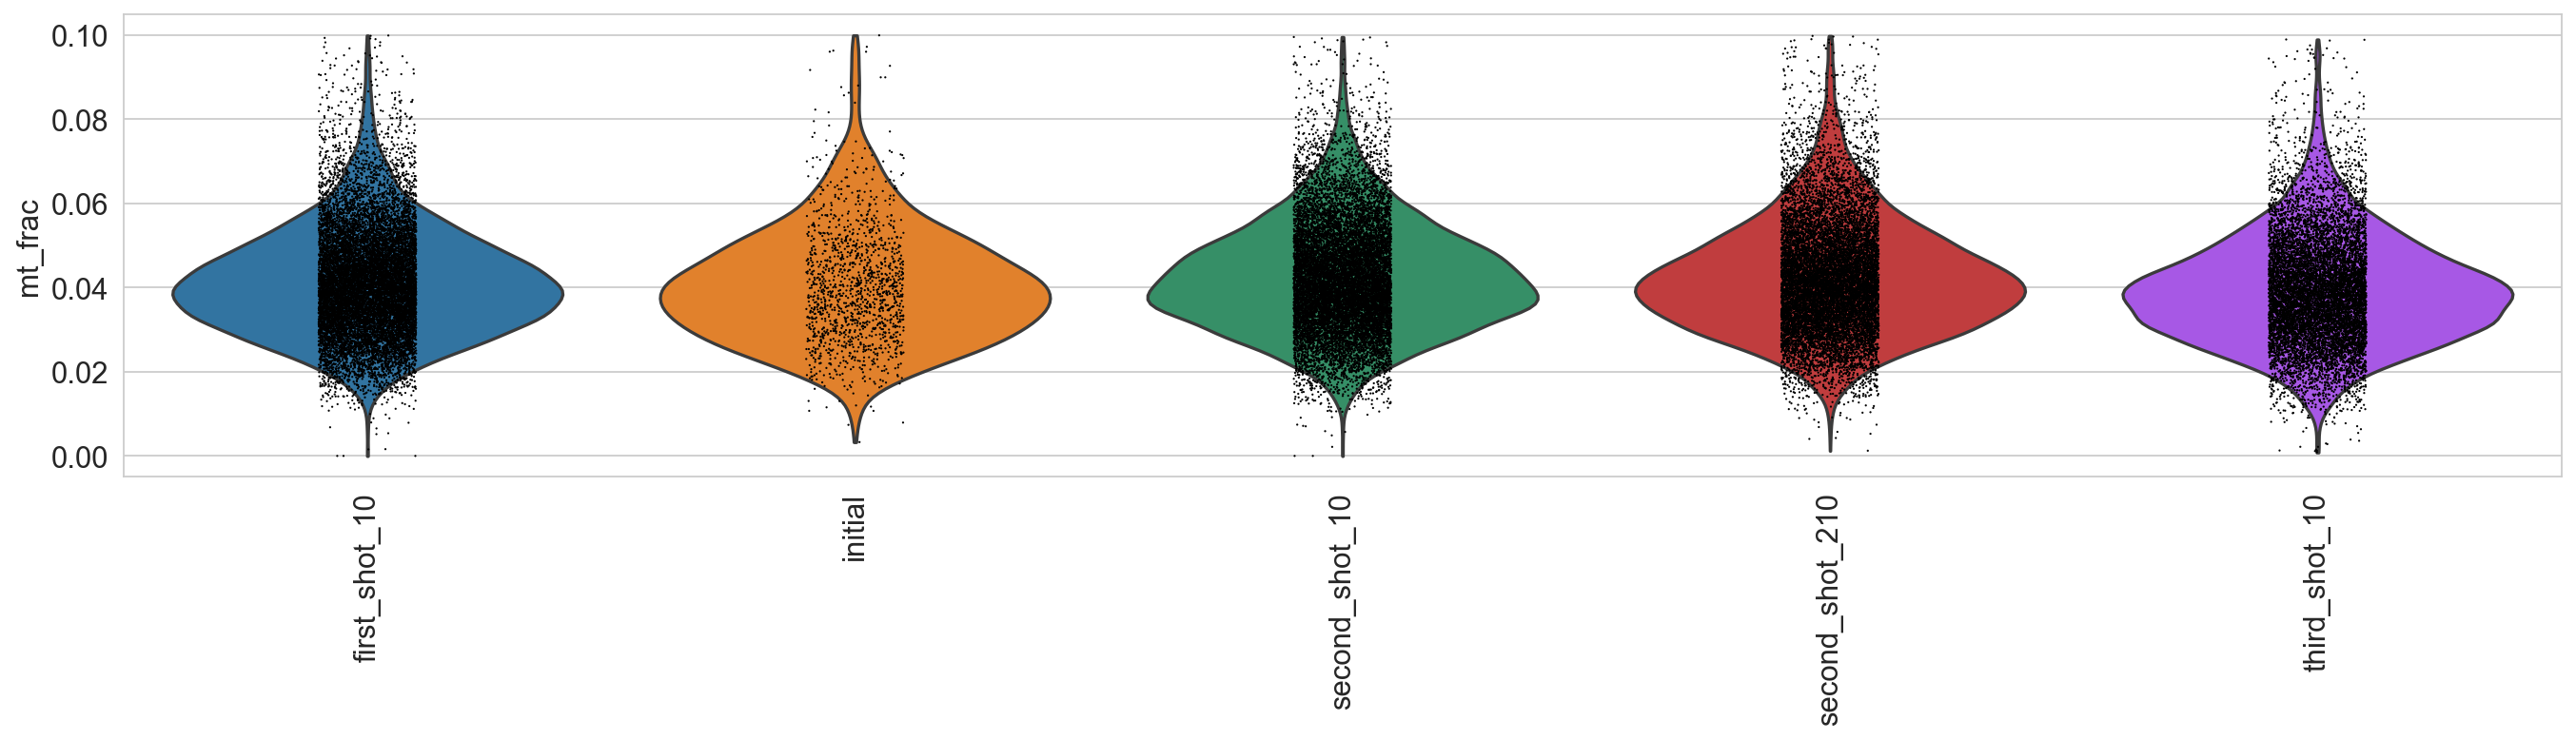

In [15]:
rcParams['figure.figsize'] = (16, 4)
sc.pl.violin(adata, ['n_counts'], size=1, log=False, rotation=90, groupby='sample')
sc.pl.violin(adata, ['log_counts'], size=1, log=False, rotation=90, groupby='sample')
sc.pl.violin(adata, ['n_genes'], size=1, log=False, rotation=90, groupby='sample')
sc.pl.violin(adata, ['mt_frac'], size=1, log=False, rotation=90, groupby='sample')

## TCR stats

In [16]:
ir.tl.chain_pairing(adata)
adata.obs['chain_pairing'].value_counts()

single pair        30393
no IR              10365
orphan VDJ          7452
extra VJ            2488
extra VDJ           1104
orphan VJ            545
two full chains      318
Name: chain_pairing, dtype: int64

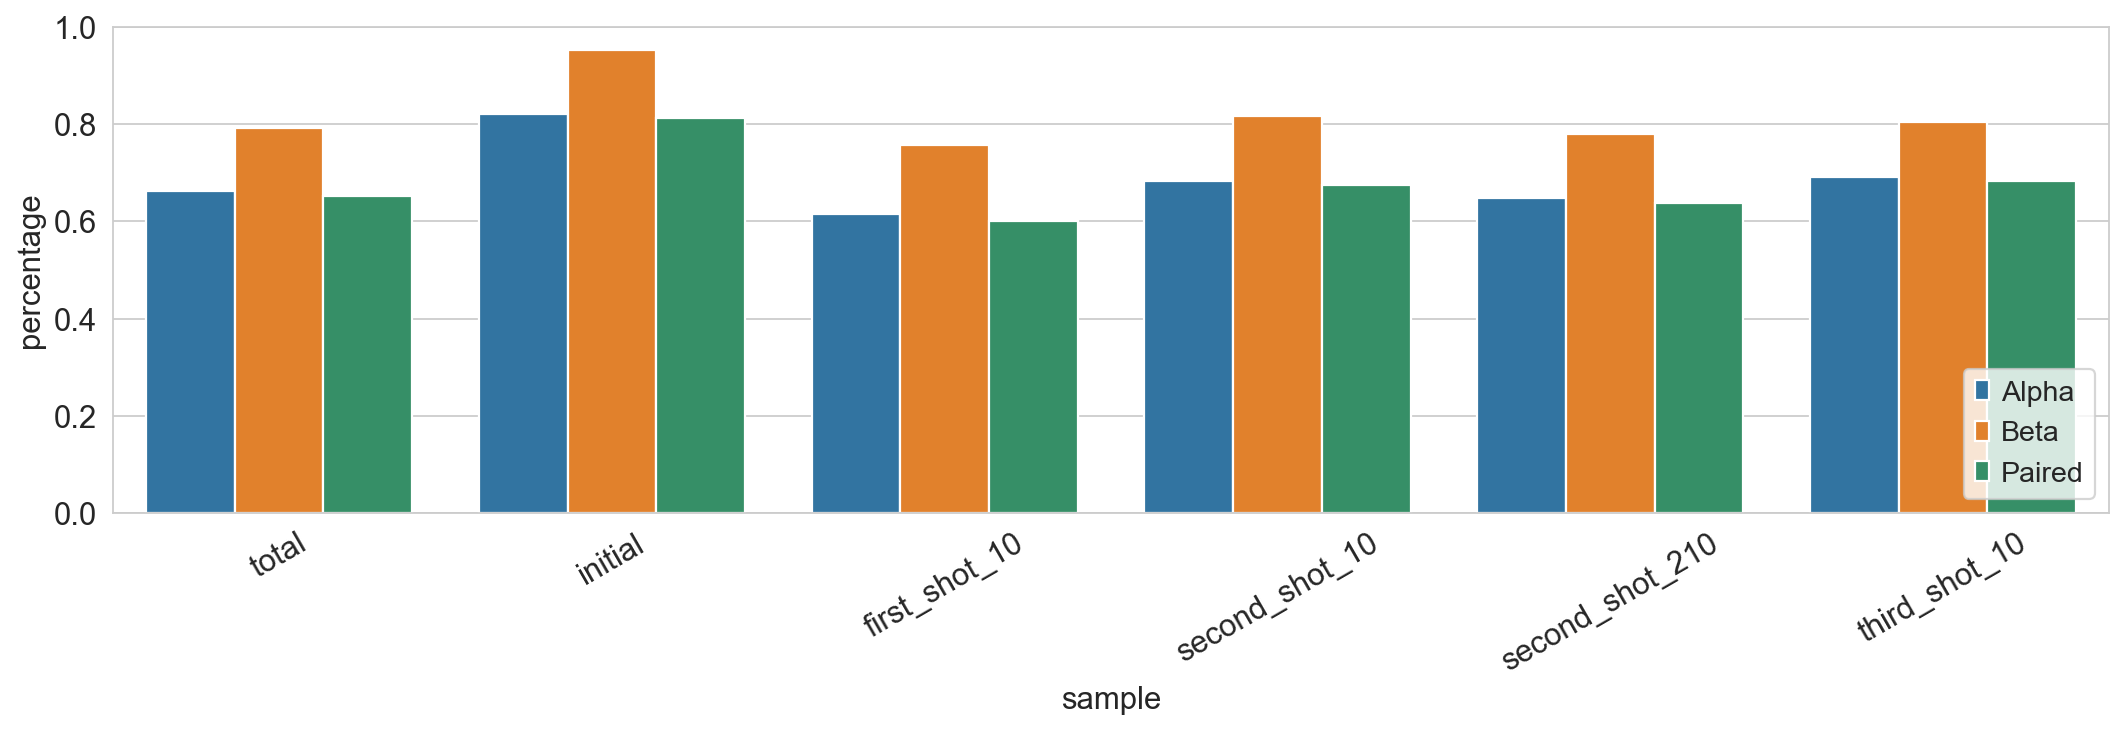

In [17]:
def get_percentages_tcr(data):
    p_alpha = data.obs['IR_VJ_1_junction_aa'].notnull().mean()
    p_beta = data.obs['IR_VDJ_1_junction_aa'].notnull().mean()
    p_paired = (data.obs['IR_VDJ_1_junction_aa'].notnull() & data.obs['IR_VJ_1_junction_aa'].notnull()).mean()
    return [p_alpha, p_beta, p_paired]

samples = ['total'] * 3
chains = ['Alpha', 'Beta', 'Paired'] * 6
percentages = get_percentages_tcr(adata)

for sample in adata.obs['sample'].unique():
    adata_tmp = adata[adata.obs['sample']==sample]
    percentages += get_percentages_tcr(adata_tmp)
    samples += [sample] * 3

df_tcr_fractions = {
    'sample': samples,
    'chain': chains,
    'percentage': percentages
}
df_tcr_fractions = pd.DataFrame(df_tcr_fractions)
g = sb.barplot(data=df_tcr_fractions, y='percentage', x='sample', hue='chain')
g.set_xticklabels(rotation=30, labels=g.get_xticklabels())
plt.legend(loc='lower right')

## Normalization

In [18]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.write(adata=adata, filename=path_merged)

normalizing counts per cell
    finished (0:00:00)


## Add ADT information

In [19]:
adata.uns['hashtags_new'] = hashtag_new
adata.uns['hashtags_old'] = hashtag_old
adata.uns['epitopes'] = epitope_ids

## Save

In [20]:
sc.write(adata=adata, filename=path_merged)